### RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?
To answer this question, we estimate a **reduced-form Panel VAR(1)** system, focusing on two outcome variables:
* `cc_pol_tax_t`: support for carbon taxes
* `cc_pol_car_t`: support for emissions standards

Each equation includes the **lagged values** of 15 attitudinal and demographic predictors. The model is estimated using **pooled OLS** with **standard errors clustered at the respondent level (`PID`)**, based on 1,722 complete observations across three survey waves.
* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Willingness to pay** (lagged):
  `ccSolve`
* **Climate policy support** (lagged):
  `cc_pol_tax`, `cc_pol_car` (to capture cross-policy influence)
* **Political identity** (lagged):
  `pol_score`, `pol_ideology` — treated as continuous variables
* **Demographic controls** (lagged):
  `dem_income`, `dem_educ`, `dem_age`, `dem_male`

The following system of two equations is estimated:
$$
\begin{cases}
\text{cc\_pol\_tax}_t = \alpha_1 + \sum_{j=1}^{15} \beta_{1j} \cdot X_{j,t-1} + \epsilon_{1t} \\
\text{cc\_pol\_car}_t = \alpha_2 + \sum_{j=1}^{15} \beta_{2j} \cdot X_{j,t-1} + \epsilon_{2t}
\end{cases}
$$

Where:
- $ X_{j,t-1} $ denotes the value of the $ j $-th predictor at time $ t-1 $  
- $ \alpha_i $ is the intercept for equation $ i $  
- $ \beta_{ij} $ is the coefficient for the effect of predictor $ j $ on outcome $ i $  
- $ \epsilon_{it} $ is the idiosyncratic error term, clustered at the respondent level

In [59]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas as pd
from scipy.stats import norm

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Define variables
demographic_vars = ["dem_income", "dem_educ", "dem_male", "dem_age"]
time_varying_vars = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "pol_score", "pol_ideology",
    "cc_pol_tax", "cc_pol_car"
]

# Create lagged versions of time-varying variables only
for var in time_varying_vars:
    data[f"{var}_lag"] = data.groupby('PID')[var].shift(1)

# Final predictors: lagged time-varying + raw demographics
lagged_vars = [f"{var}_lag" for var in time_varying_vars]
all_predictors = lagged_vars + demographic_vars

# Drop NA
panel_var_data = data.dropna(subset=all_predictors + ["cc_pol_tax", "cc_pol_car"])

# --- Model 1: cc_pol_tax_t
X1 = sm.add_constant(panel_var_data[all_predictors])
y1 = panel_var_data["cc_pol_tax"]
model1 = sm.OLS(y1, X1).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# --- Model 2: cc_pol_car_t
X2 = sm.add_constant(panel_var_data[all_predictors])
y2 = panel_var_data["cc_pol_car"]
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Print side-by-side summary
print(summary_col(
    [model1, model2],
    stars=True,
    model_names=["cc_pol_tax_t", "cc_pol_car_t"],
    info_dict={"N": lambda x: f"{int(x.nobs)}"}
))

# === Save model summaries to CSV ===
def extract_model_summary(model, alpha=0.05):
    params = model.params
    std_errors = model.bse
    z = abs(norm.ppf(alpha / 2))
    lower = params - z * std_errors
    upper = params + z * std_errors
    significant = ~((lower <= 0) & (upper >= 0))

    return pd.DataFrame({
        "mean": params,
        "std": std_errors,
        "2.5%": lower,
        "97.5%": upper,
        "significant": significant
    })

summary_tax = extract_model_summary(model1)
summary_car = extract_model_summary(model2)

summary_tax.to_csv("../results/model_summary_tax.csv")
summary_car.to_csv("../results/model_summary_car.csv")
print("Summaries saved to ../results/model_summary_tax.csv and model_summary_car.csv")

print(summary_tax)
print(summary_car)


                 cc_pol_tax_t cc_pol_car_t
------------------------------------------
const            0.5288***    0.7192***   
                 (0.1435)     (0.1433)    
cc4_world_lag    0.1839***    0.1510***   
                 (0.0306)     (0.0296)    
cc4_wealthUS_lag -0.0440*     -0.0520**   
                 (0.0250)     (0.0219)    
cc4_poorUS_lag   0.0606**     0.0962***   
                 (0.0302)     (0.0301)    
cc4_comm_lag     -0.0251      0.0073      
                 (0.0366)     (0.0333)    
cc4_famheal_lag  -0.0012      0.0012      
                 (0.0347)     (0.0305)    
cc4_famecon_lag  0.0184       -0.0202     
                 (0.0254)     (0.0229)    
ccSolve_lag      0.0896***    0.0165      
                 (0.0222)     (0.0189)    
pol_score_lag    -0.1063***   -0.0378**   
                 (0.0190)     (0.0168)    
pol_ideology_lag 0.0368       0.0604**    
                 (0.0301)     (0.0274)    
cc_pol_tax_lag   0.3434***    0.1044***   
          

In [60]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from tqdm import tqdm

# # --- Step 0: Define predictors ---
# demographic_vars = ["dem_income", "dem_educ", "dem_male", "dem_age"]
# time_varying_vars = [
#     "cc4_world", "cc4_wealthUS", "cc4_poorUS",
#     "cc4_comm", "cc4_famheal", "cc4_famecon",
#     "ccSolve", "pol_score", "pol_ideology"
# ]
# endogenous_lags = ["cc_pol_tax_lag", "cc_pol_car_lag"]
# lagged_vars = [f"{var}_lag" for var in time_varying_vars] + endogenous_lags
# all_predictors = lagged_vars + demographic_vars

# # --- Step 1: Load panel_var_data ---
# data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
# data = data.sort_values(by=["PID", "WAVE"])

# # Create lags
# for var in time_varying_vars:
#     data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# # Manually add cc_pol_tax_lag and cc_pol_car_lag
# data["cc_pol_tax_lag"] = data.groupby("PID")["cc_pol_tax"].shift(1)
# data["cc_pol_car_lag"] = data.groupby("PID")["cc_pol_car"].shift(1)

# # Drop rows with missing data
# panel_var_data = data.dropna(subset=all_predictors + ["cc_pol_tax", "cc_pol_car"])
# pids = panel_var_data['PID'].unique()

# # --- Step 2: Bootstrapping ---
# n_bootstraps = 1000
# boot_coefs_tax, boot_coefs_car = [], []

# for _ in tqdm(range(n_bootstraps)):
#     sampled_pids = np.random.choice(pids, size=len(pids), replace=True)
#     boot_data = pd.concat([panel_var_data[panel_var_data['PID'] == pid] for pid in sampled_pids])

#     X_boot = sm.add_constant(boot_data[all_predictors])
#     y_boot_tax = boot_data["cc_pol_tax"]
#     y_boot_car = boot_data["cc_pol_car"]

#     try:
#         m_tax = sm.OLS(y_boot_tax, X_boot).fit()
#         m_car = sm.OLS(y_boot_car, X_boot).fit()
#         boot_coefs_tax.append(m_tax.params)
#         boot_coefs_car.append(m_car.params)
#     except Exception:
#         continue

# # --- Step 3: Summarize results ---
# def summarize_bootstrap(df):
#     summary = df.describe(percentiles=[0.025, 0.975]).T[['mean', 'std', '2.5%', '97.5%']]
#     summary['significant'] = ~((summary['2.5%'] <= 0) & (summary['97.5%'] >= 0))
#     return summary

# summary_boot_tax = summarize_bootstrap(pd.DataFrame(boot_coefs_tax))
# summary_boot_car = summarize_bootstrap(pd.DataFrame(boot_coefs_car))

# # Print summaries
# print(summary_boot_tax)
# print(summary_boot_car)

# # --- Step 4: Save summaries ---
# summary_boot_tax.to_csv("../results/bootstrapped_rq1_tax.csv")
# summary_boot_car.to_csv("../results/bootstrapped_rq1_car.csv")
# print("Bootstrapped summaries saved.")

In [61]:
import pandas as pd
from scipy.stats import norm

# Load model and bootstrap summaries
model_tax = pd.read_csv("../results/model_summary_tax.csv", index_col=0)
boot_tax = pd.read_csv("../results/bootstrapped_rq1_tax.csv", index_col=0)
model_car = pd.read_csv("../results/model_summary_car.csv", index_col=0)
boot_car = pd.read_csv("../results/bootstrapped_rq1_car.csv", index_col=0)

# Helper: determine if CI excludes 0
def bootstrap_significance(ci_lower, ci_upper):
    return "Yes" if ci_lower > 0 or ci_upper < 0 else "No"

def build_comparison(model_df, boot_df):
    comparison = []
    shared_vars = model_df.index.intersection(boot_df.index)

    for var in shared_vars:
        coef = model_df.loc[var, "mean"]
        se = model_df.loc[var, "std"]
        z = abs(coef / se)
        pval = 2 * (1 - norm.cdf(z))
        model_sig = "Yes" if pval < 0.05 else "No"

        ci_lower = boot_df.loc[var, "2.5%"]
        ci_upper = boot_df.loc[var, "97.5%"]
        boot_sig = bootstrap_significance(ci_lower, ci_upper)

        if model_sig == "Yes" and boot_sig == "Yes":
            note = "Agreement"
        elif model_sig == "No" and boot_sig == "No":
            note = "Agreement"
        elif model_sig == "Yes" and boot_sig == "No":
            note = "Partial disagreement"
        elif model_sig == "No" and boot_sig == "Yes":
            note = "Bootstrap-only significance"
        else:
            note = "Unclear"

        comparison.append({
            "Variable": var,
            "Model p-value": round(pval, 4),
            "Bootstrap significant?": boot_sig,
            "Notes": note
        })
    
    return pd.DataFrame(comparison)

# --- Tax model comparison
comparison_tax = build_comparison(model_tax, boot_tax)
comparison_tax.to_csv("../results/comparison_tax_model_vs_bootstrap.csv", index=False)
print("Saved: ../results/comparison_tax_model_vs_bootstrap.csv")

# --- Car model comparison
comparison_car = build_comparison(model_car, boot_car)
comparison_car.to_csv("../results/comparison_car_model_vs_bootstrap.csv", index=False)
print("Saved: ../results/comparison_car_model_vs_bootstrap.csv")

# Optional: show previews
print("\nTax Model Comparison:")
print(comparison_tax.to_string(index=False))

print("\nCar Model Comparison:")
print(comparison_car.to_string(index=False))

Saved: ../results/comparison_tax_model_vs_bootstrap.csv
Saved: ../results/comparison_car_model_vs_bootstrap.csv

Tax Model Comparison:
        Variable  Model p-value Bootstrap significant?     Notes
           const         0.0002                    Yes Agreement
   cc4_world_lag         0.0000                    Yes Agreement
cc4_wealthUS_lag         0.0790                     No Agreement
  cc4_poorUS_lag         0.0451                    Yes Agreement
    cc4_comm_lag         0.4927                     No Agreement
 cc4_famheal_lag         0.9732                     No Agreement
 cc4_famecon_lag         0.4677                     No Agreement
     ccSolve_lag         0.0001                    Yes Agreement
   pol_score_lag         0.0000                    Yes Agreement
pol_ideology_lag         0.2216                     No Agreement
  cc_pol_tax_lag         0.0000                    Yes Agreement
  cc_pol_car_lag         0.0000                    Yes Agreement
      dem_income    

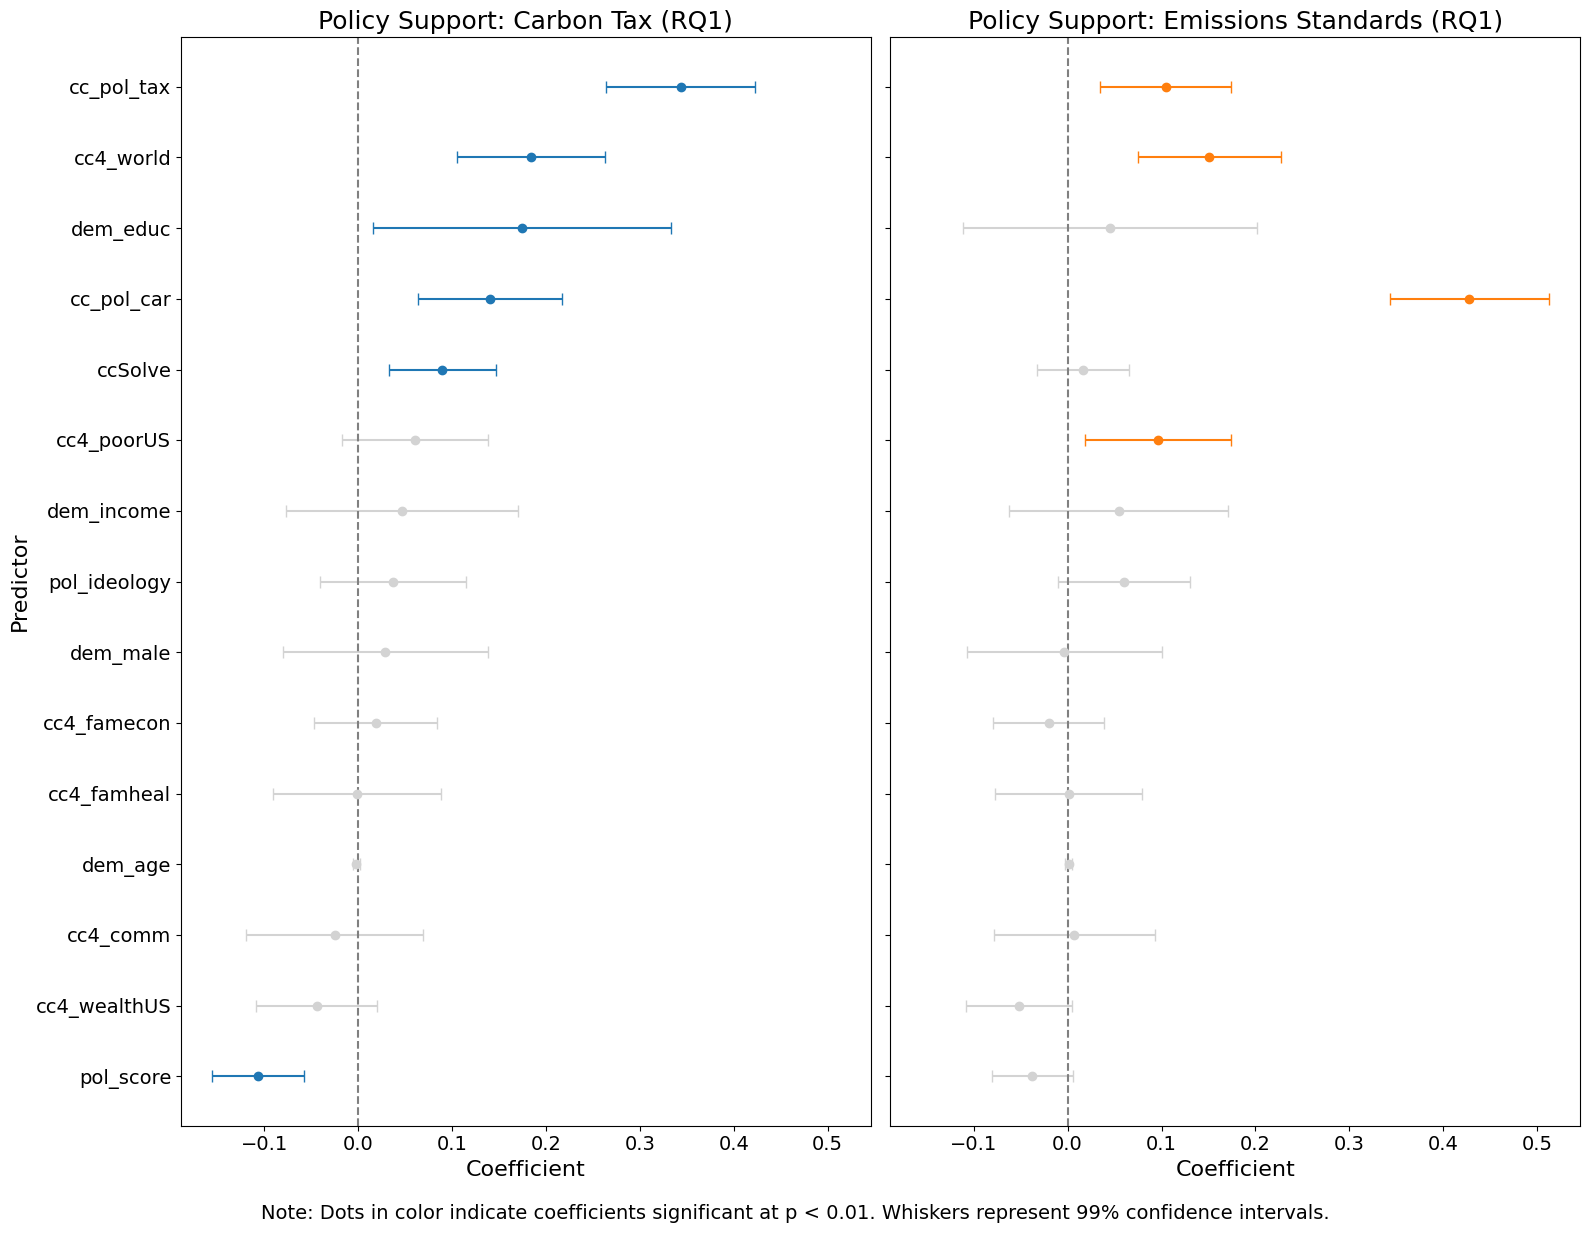

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues  # Get p-values from model

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values,
        'model': label
    }).query("predictor != 'const'")

    # New threshold: p < 0.01 via p-value
    df['significant'] = df['pval'] < 0.01

    # Clean labels
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    return df.sort_values(by='coef', ascending=True)

# --- Extract separately
df_tax = extract_model_info(model1, "cc_pol_tax_t")
df_car = extract_model_info(model2, "cc_pol_car_t")

# --- Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)

for i, (ax, df, title, color) in enumerate(zip(
    axs,
    [df_tax, df_car],
    ["Policy Support: Carbon Tax (RQ1)", "Policy Support: Emissions Standards (RQ1)"],
    ["tab:blue", "tab:orange"]
)):
    for _, row in df.iterrows():
        plot_color = color if row['significant'] else 'lightgray'
        ax.errorbar(
            row['coef'],
            row['predictor'],
            xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
            fmt='o',
            color=plot_color,
            ecolor=plot_color,
            capsize=4
        )
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Coefficient", fontsize=16)
    if i == 0:
        ax.set_ylabel("Predictor", fontsize=16)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
fig.text(
    0.5, -0.02,
    "Note: Dots in color indicate coefficients significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=14
)
plt.savefig("../results/rq1_dot_whisker_policy_support.png", dpi=600, bbox_inches='tight')
plt.show()


> **Note:** Coefficients are sorted by their signed value (not absolute size) to reflect both magnitude (how strong) and direction of effect (positive or negative). Predictors whose 95% confidence intervals include zero (that are not statistically significant) are displayed in gray. This helps focus attention on the variables that clearly have an effect.
> 
> **Why not use absolute coefficients?**  
> Sorting by absolute coefficient size would show the predictors with the strongest effects first, regardless of whether those effects are positive or negative. However, in this analysis, we wanted to highlight **the direction** of each effect (e.g., does it increase or decrease support?). That’s why we sorted by the raw coefficient values - so variables that reduce support appear on one side of the plot, and those that increase it appear on the other.

> **Interpreting a Dot-Whisker Plot**
> A **dot-whisker plot** visualizes the results of regression models by showing each variable’s estimated effect and the uncertainty around it.
> * **Dots** represent **point estimates** (e.g., regression coefficients)
>   * Each dot shows the estimated impact of a predictor variable on the outcome.
> * **Whiskers (horizontal lines)** represent the **confidence intervals** around the estimates
>   * In this plot, we use **99% confidence intervals** (corresponding to **p < 0.01**).
>   * The wider the whisker, the greater the uncertainty in the estimate.
> * A **vertical line at zero** represents **no effect**
>   * If a whisker **crosses zero**, the effect is **not statistically significant** at the 99% level.
>   * If it **does not cross zero**, the effect is considered **statistically significant at p < 0.01**.
>
> This plot helps identify which predictors have **strong, highly significant effects**, and which are more uncertain or weaker. It reflects a stricter approach to significance, focusing only on the most robust relationships.

In [63]:
# Create a subgroup table for combinations of gender, income, and education
grouped = panel_var_data.groupby(['dem_male', 'dem_income', 'dem_educ']).size().reset_index(name='count')

# Sort to see the smallest subgroups first
grouped_sorted = grouped.sort_values('count')

# Print the full sorted table
print("Subgroup sizes (gender x income x education):")
print(grouped_sorted)

# Optional: Highlight any subgroup smaller than a threshold (e.g., 50)
threshold = 50
small_groups = grouped_sorted[grouped_sorted['count'] < threshold]

print(f"\nSubgroups with fewer than {threshold} observations:")
print(small_groups)

Subgroup sizes (gender x income x education):
   dem_male  dem_income  dem_educ  count
5         1           0         1     40
1         0           0         1     42
3         0           1         1     46
7         1           1         1    116
2         0           1         0    150
6         1           1         0    212
4         1           0         0    454
0         0           0         0    662

Subgroups with fewer than 50 observations:
   dem_male  dem_income  dem_educ  count
5         1           0         1     40
1         0           0         1     42
3         0           1         1     46


#### Panel VAR Analysis – RQ1 
*RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?*

The results show that people support carbon taxes and emissions standards more when they believe:
* Climate change harms the world (`cc4_world`)
* Poor people in the U.S. are disproportionately affected (`cc4_poorUS`)

Support is also strongly predicted by prior attitudes: individuals who previously supported either policy are significantly more likely to continue supporting it (`cc_pol_tax`, `cc_pol_car`). This suggests that policy support is **stable over time**, even during an election period.

However, **personal or community-level perceptions of harm** — such as concern about one’s own community or family health — do **not** significantly influence support at the stricter p < 0.01 level.

In the case of **carbon taxes specifically**, two additional factors stand out:
* **Higher education levels** are associated with greater support (`dem_educ`)
* **More conservative political orientation** is associated with lower support (`pol_score`)

These findings suggest that **global concern, fairness, and prior support** are the most robust drivers of climate policy support during elections.

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Combine predictors into one matrix (same for both models) ---
X = panel_var_data[all_predictors]
X = sm.add_constant(X)

# --- Calculate VIF ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Remove constant (optional)
vif_data = vif_data[vif_data["Variable"] != "const"]

# Add interpretation column
def interpret_vif(v):
    if v > 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif v > 5:
        return "Moderate multicollinearity (monitor closely)"
    elif v > 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

# Sort and print
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False))

        Variable      VIF                                             Interpretation
    cc4_comm_lag 4.660211 Some correlation (acceptable, but check related variables)
 cc4_famheal_lag 4.222213 Some correlation (acceptable, but check related variables)
  cc4_poorUS_lag 3.939435 Some correlation (acceptable, but check related variables)
   cc4_world_lag 3.598260 Some correlation (acceptable, but check related variables)
 cc4_famecon_lag 2.443232 Some correlation (acceptable, but check related variables)
cc4_wealthUS_lag 2.378119 Some correlation (acceptable, but check related variables)
  cc_pol_car_lag 2.167202 Some correlation (acceptable, but check related variables)
  cc_pol_tax_lag 2.161100 Some correlation (acceptable, but check related variables)
   pol_score_lag 1.992538            Low correlation (no multicollinearity concerns)
pol_ideology_lag 1.943864            Low correlation (no multicollinearity concerns)
      dem_income 1.163293            Low correlation (no multicol

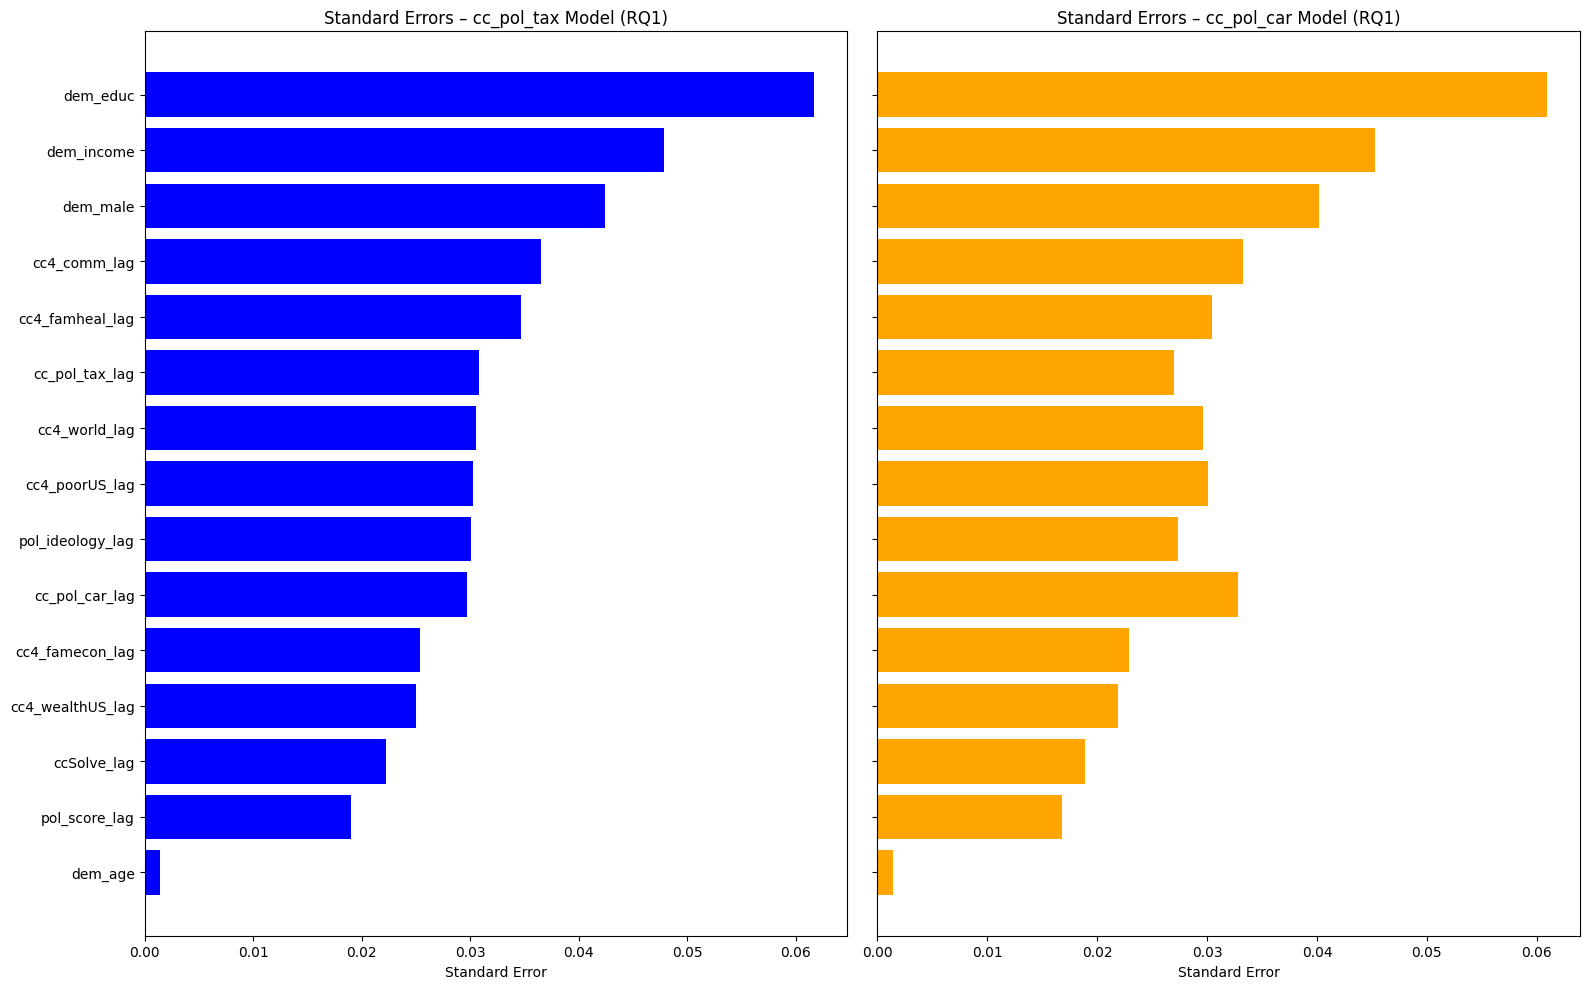

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Create DataFrame for standard error inspection (Model 1: cc_pol_tax) ---
se_model1 = pd.DataFrame({
    'Predictor': model1.params.index,
    'Estimate': model1.params.values,
    'StdError': model1.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Create DataFrame for standard error inspection (Model 2: cc_pol_car) ---
se_model2 = pd.DataFrame({
    'Predictor': model2.params.index,
    'Estimate': model2.params.values,
    'StdError': model2.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Create horizontal subplot layout (side by side)
fig, axes = plt.subplots(ncols=2, figsize=(16, 10), sharey=True)

# Plot for cc_pol_tax model (left)
axes[0].barh(se_model1['Predictor'], se_model1['StdError'], color='blue')
axes[0].set_title('Standard Errors – cc_pol_tax Model (RQ1)')
axes[0].set_xlabel('Standard Error')
axes[0].invert_yaxis()

# Plot for cc_pol_car model (right)
axes[1].barh(se_model2['Predictor'], se_model2['StdError'], color='orange')
axes[1].set_title('Standard Errors – cc_pol_car Model (RQ1)')
axes[1].set_xlabel('Standard Error')

# --- Final layout and save
plt.tight_layout()
plt.savefig("../results/rq1_se_barplot_combined_side_by_side.png", dpi=600)
plt.show()

* The demographic variables `dem_educ_lag`, `dem_income_lag`, and `dem_male_lag` have the **highest standard errors** in both the carbon tax and emissions standards models.
* These high standard errors suggest that these variables contribute the most to **model uncertainty**.
* This aligns with the **wide confidence intervals** (long whiskers) observed for these variables in the dot-whisker plots.
* Although the variables may be **conceptually important**, the model is not confident in their estimated effects.
* Possible reasons for this uncertainty include:
  * **Limited variation** across survey waves,
  * **Collinearity** between demographic predictors (e.g., income and education),
  * **Small subgroup sizes** for certain demographic categories (e.g., by gender or education level).

---

### RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?
To investigate how willingness to financially support climate action evolves over time and whether it shifts during election periods, we estimate a **reduced-form Panel VAR(1)** model with `ccSolve_t` (willingness to pay for climate solutions) as the dependent variable.

The model includes the **lagged values** of 15 time-varying predictors capturing climate harm perceptions, policy attitudes, political identity, and demographic characteristics:
* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Policy support** (lagged):
  `cc_pol_tax`, `cc_pol_car`
* **Willingness to pay (lagged)**:
  `ccSolve` (included as its own lag to model temporal dynamics)
* **Political identity** (lagged):
  `pol_score`, `pol_ideology` — treated as continuous variables
* **Demographics** (lagged):
  `dem_income`, `dem_age`, `dem_educ`, `dem_male`

The full equation is:

$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{15} \beta_j \cdot X_{j,t-1} 
+ \epsilon_t
$$

Where:

* $X_{j,t-1}$ denotes the 15 lagged predictors
* $ \alpha $ is the intercept
* $ \epsilon_t $ is the individual-level error term, **clustered by respondent (`PID`)**

The model is estimated using **pooled OLS with cluster-robust standard errors**, based on 1,722 complete observations from three survey waves.

This specification allows us to assess not only which **attitudinal, political, or demographic factors** predict higher or lower willingness to pay for climate action, but also whether the **election period itself exerts a distinct effect**, controlling for prior beliefs and identities.

In [66]:
import statsmodels.api as sm
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Define variable groups
demographic_vars = ["dem_income", "dem_educ", "dem_male", "dem_age"]  # non-lagged
time_varying_vars = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "pol_score", "pol_ideology",
    "cc_pol_tax", "cc_pol_car"
]

# Optionally include autoregressive term
include_ccSolve_lag = True

# Create lags
for var in time_varying_vars:
    data[f'{var}_lag'] = data.groupby('PID')[var].shift(1)

if include_ccSolve_lag:
    data['ccSolve_lag'] = data.groupby('PID')['ccSolve'].shift(1)

# Predictors
lagged_vars = [f"{var}_lag" for var in time_varying_vars]
if include_ccSolve_lag:
    lagged_vars.append("ccSolve_lag")
all_predictors = lagged_vars + demographic_vars

# Clean data
panel_var_data = data.dropna(subset=all_predictors + ['ccSolve'])

# Model
X = sm.add_constant(panel_var_data[all_predictors])
y = panel_var_data['ccSolve']
rq2_model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Summary formatting
conf_int = rq2_model.conf_int()
summary_df = pd.DataFrame({
    "mean": rq2_model.params,
    "std": rq2_model.bse,
    "2.5%": conf_int[0],
    "97.5%": conf_int[1],
})
summary_df["significant"] = ~((summary_df["2.5%"] <= 0) & (summary_df["97.5%"] >= 0))

# Save
summary_df.to_csv("../results/model_summary_ccSolve.csv")
print("Model summary saved to ../results/model_summary_ccSolve.csv")
print(summary_df)

Model summary saved to ../results/model_summary_ccSolve.csv
                      mean       std      2.5%     97.5%  significant
const             1.039958  0.152767  0.740541  1.339376         True
cc4_world_lag     0.058542  0.035761 -0.011548  0.128633        False
cc4_wealthUS_lag  0.009243  0.028961 -0.047520  0.066005        False
cc4_poorUS_lag    0.028936  0.033930 -0.037565  0.095437        False
cc4_comm_lag     -0.054913  0.043017 -0.139225  0.029398        False
cc4_famheal_lag   0.042279  0.041970 -0.039981  0.124539        False
cc4_famecon_lag   0.029014  0.029025 -0.027873  0.085901        False
pol_score_lag     0.006053  0.018435 -0.030078  0.042185        False
pol_ideology_lag  0.045121  0.034123 -0.021758  0.112000        False
cc_pol_tax_lag    0.108525  0.025146  0.059240  0.157810         True
cc_pol_car_lag   -0.032005  0.025274 -0.081541  0.017531        False
ccSolve_lag       0.049676  0.027426 -0.004079  0.103431        False
dem_income        0.064474  0.

In [67]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from tqdm import tqdm

# # Load and sort data
# data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
# data = data.sort_values(by=['PID', 'WAVE'])

# # Define variable sets
# demographic_vars = ["dem_income", "dem_educ", "dem_male", "dem_age"]
# time_varying_vars = [
#     "cc4_world", "cc4_wealthUS", "cc4_poorUS",
#     "cc4_comm", "cc4_famheal", "cc4_famecon",
#     "pol_score", "pol_ideology",
#     "cc_pol_tax", "cc_pol_car"
# ]

# # Create lagged versions of time-varying predictors
# for var in time_varying_vars:
#     data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# # Optional: include ccSolve_lag
# include_ccSolve_lag = True
# if include_ccSolve_lag:
#     data['ccSolve_lag'] = data.groupby("PID")["ccSolve"].shift(1)

# # Build final predictor list
# lagged_vars = [f"{var}_lag" for var in time_varying_vars]
# if include_ccSolve_lag:
#     lagged_vars.append("ccSolve_lag")
# all_predictors = lagged_vars + demographic_vars

# # Drop missing data
# panel_var_data = data.dropna(subset=all_predictors + ['ccSolve'])

# # Bootstrapping setup
# n_bootstraps = 1000
# pids = panel_var_data['PID'].unique()
# boot_coefs = []

# for _ in tqdm(range(n_bootstraps)):
#     sampled_pids = np.random.choice(pids, size=len(pids), replace=True)
#     boot_data = pd.concat([panel_var_data[panel_var_data['PID'] == pid] for pid in sampled_pids])

#     X_boot = sm.add_constant(boot_data[all_predictors])
#     y_boot = boot_data["ccSolve"]

#     try:
#         model = sm.OLS(y_boot, X_boot).fit()
#         boot_coefs.append(model.params)
#     except:
#         continue  # skip failed iterations

# # Create summary DataFrame
# boot_df = pd.DataFrame(boot_coefs)
# summary = boot_df.describe(percentiles=[0.025, 0.975]).T[['mean', 'std', '2.5%', '97.5%']]
# summary['significant'] = ~((summary['2.5%'] <= 0) & (summary['97.5%'] >= 0))

# # Output
# print(summary)
# summary.to_csv("../results/bootstrapped_rq2_ccsolve.csv")

In [68]:
import pandas as pd
from scipy.stats import norm

# Load model summary and bootstrap results
model_df = pd.read_csv("../results/model_summary_ccsolve.csv", index_col=0)
boot_df = pd.read_csv("../results/bootstrapped_rq2_ccsolve.csv", index_col=0)

# Helper to check if CI excludes 0
def bootstrap_significance(ci_lower, ci_upper):
    return "Yes" if ci_lower > 0 or ci_upper < 0 else "No"

# Create comparison table
comparison = []

shared_vars = model_df.index.intersection(boot_df.index)

for var in shared_vars:
    coef = model_df.loc[var, "mean"]
    se = model_df.loc[var, "std"]

    # Compute p-value
    z = abs(coef / se)
    pval = 2 * (1 - norm.cdf(z))
    model_sig = "Yes" if pval < 0.05 else "No"

    # Bootstrap CI
    ci_lower = boot_df.loc[var, "2.5%"]
    ci_upper = boot_df.loc[var, "97.5%"]
    boot_sig = bootstrap_significance(ci_lower, ci_upper)

    # Note on agreement
    if model_sig == "Yes" and boot_sig == "Yes":
        note = "Agreement"
    elif model_sig == "No" and boot_sig == "No":
        note = "Agreement"
    elif model_sig == "Yes" and boot_sig == "No":
        note = "Partial disagreement"
    elif model_sig == "No" and boot_sig == "Yes":
        note = "Bootstrap-only significance"
    else:
        note = "Unclear"

    comparison.append({
        "Variable": var,
        "Model p-value": round(pval, 4),
        "Bootstrap significant?": boot_sig,
        "Notes": note
    })

# Save and print
comparison_df = pd.DataFrame(comparison)
comparison_df.to_csv("../results/comparison_rq2_model_vs_bootstrap.csv", index=False)

print("\nRQ2 Model vs Bootstrap comparison saved to:")
print("../results/comparison_rq2_model_vs_bootstrap.csv")
print("\nPreview:")
print(comparison_df.to_string(index=False))


RQ2 Model vs Bootstrap comparison saved to:
../results/comparison_rq2_model_vs_bootstrap.csv

Preview:
        Variable  Model p-value Bootstrap significant?                       Notes
           const         0.0000                    Yes                   Agreement
   cc4_world_lag         0.1016                     No                   Agreement
cc4_wealthUS_lag         0.7496                     No                   Agreement
  cc4_poorUS_lag         0.3938                     No                   Agreement
    cc4_comm_lag         0.2018                     No                   Agreement
 cc4_famheal_lag         0.3138                     No                   Agreement
 cc4_famecon_lag         0.3175                     No                   Agreement
   pol_score_lag         0.7426                     No                   Agreement
pol_ideology_lag         0.1861                     No                   Agreement
  cc_pol_tax_lag         0.0000                    Yes            

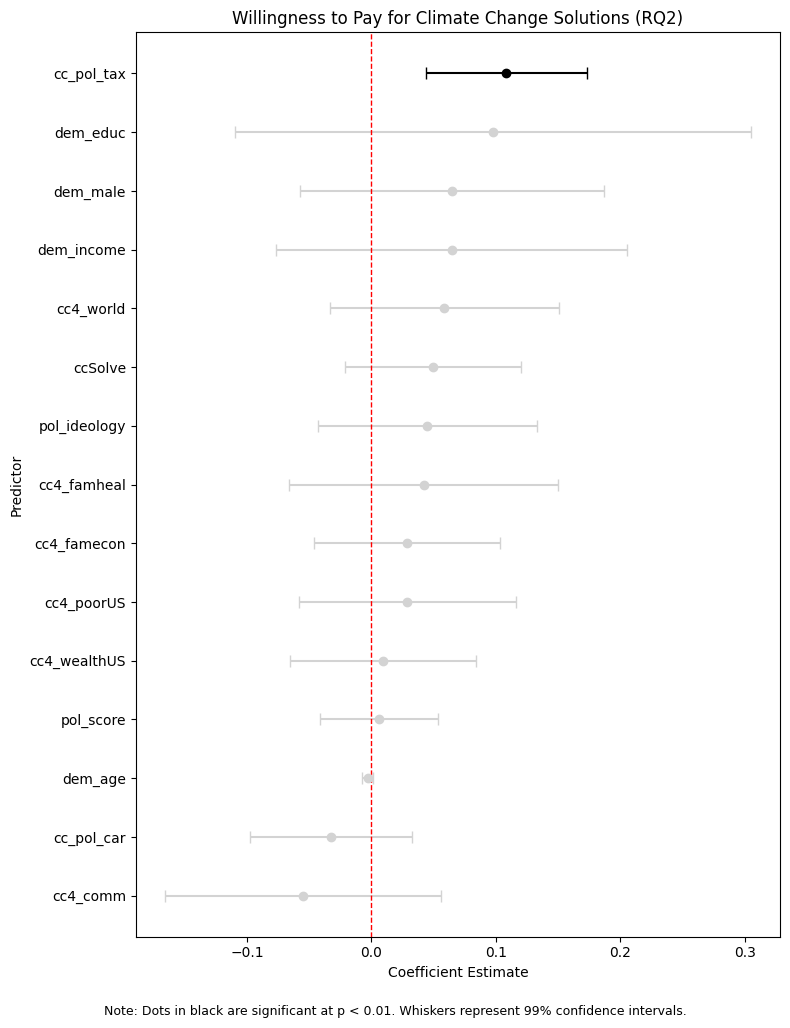

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Step 1: Extract model coefficients and confidence intervals
def extract_model_info(model):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues  # Extract p-values

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")  # exclude intercept

    # --- Previous threshold: p < 0.05 via 95% CI exclusion
    # df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))

    # --- New threshold: p < 0.01
    df['significant'] = df['pval'] < 0.01
    return df

# --- Step 2: Extract info and sort predictors
plot_df = extract_model_info(rq2_model)
plot_df['predictor'] = plot_df['predictor'].str.replace('_lag', '', regex=False)
plot_df = plot_df.sort_values(by='coef', ascending=True)

# --- Step 3: Plot
plt.figure(figsize=(8, 10))

for _, row in plot_df.iterrows():
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color='black' if row['significant'] else 'lightgray',
        ecolor='black' if row['significant'] else 'lightgray',
        capsize=4
    )

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title("Willingness to Pay for Climate Change Solutions (RQ2)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor")

# --- Add caption
plt.figtext(
    0.5, -0.02,
    "Note: Dots in black are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=9
)

plt.tight_layout()
plt.savefig("../results/rq2_dot_whisker_ccSolve_coefficients.png", dpi=600)
plt.show()

#### Panel VAR Analysis – RQ2
*RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?*

> **Willingness to pay for climate solutions does not appear to change significantly during elections.**
> 
> Among all the predictors, **only one variable** — **prior support for a carbon tax (`cc_pol_tax`)** — is a **strong and statistically significant predictor** of willingness to pay for climate solutions (`ccSolve`). This suggests that people who already support climate measures are more likely to express financial willingness to contribute to solutions.
> 
> **No other factors**, including perceptions of climate harm to the world, the poor, the wealthy, or one’s community, show statistically significant associations at the stricter p < 0.01 level. Demographics (e.g., age, gender, education, income) and political orientation also do **not** show strong effects in this model.
> 
> **Therefore, the answer to RQ2 is that willingness to pay is stable across the election period** and is **primarily influenced by existing policy support (carbon tax)**.

In [70]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define predictors
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# Create lagged versions
data = data.sort_values(by=['PID', 'WAVE'])
for var in variables:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

lagged_vars = [f"{v}_lag" for v in variables]
data = data.dropna(subset=lagged_vars + ['ccSolve'])

# VIF input matrix
X = data[lagged_vars]
X = sm.add_constant(X)

# Compute VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop intercept
vif_data = vif_data[vif_data["Variable"] != "const"]

# Add interpretation column
def interpret_vif(v):
    if v > 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif v > 5:
        return "Moderate multicollinearity (monitor closely)"
    elif v > 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

# Sort by VIF
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Display the result
print(vif_data.to_string(index=False))

        Variable      VIF                                             Interpretation
    cc4_comm_lag 4.657229 Some correlation (acceptable, but check related variables)
 cc4_famheal_lag 4.222811 Some correlation (acceptable, but check related variables)
  cc4_poorUS_lag 3.940439 Some correlation (acceptable, but check related variables)
   cc4_world_lag 3.600301 Some correlation (acceptable, but check related variables)
 cc4_famecon_lag 2.441409 Some correlation (acceptable, but check related variables)
cc4_wealthUS_lag 2.380742 Some correlation (acceptable, but check related variables)
  cc_pol_car_lag 2.165414 Some correlation (acceptable, but check related variables)
  cc_pol_tax_lag 2.161270 Some correlation (acceptable, but check related variables)
   pol_score_lag 1.988586            Low correlation (no multicollinearity concerns)
pol_ideology_lag 1.940963            Low correlation (no multicollinearity concerns)
  dem_income_lag 1.148649            Low correlation (no multicol

Top variables with largest standard errors in RQ2 (ccSolve model):
       Predictor  Estimate  StdError
        dem_educ  0.097500  0.080513
      dem_income  0.064474  0.054687
        dem_male  0.064725  0.047464
    cc4_comm_lag -0.054913  0.043017
 cc4_famheal_lag  0.042279  0.041970
   cc4_world_lag  0.058542  0.035761
pol_ideology_lag  0.045121  0.034123
  cc4_poorUS_lag  0.028936  0.033930
 cc4_famecon_lag  0.029014  0.029025
cc4_wealthUS_lag  0.009243  0.028961


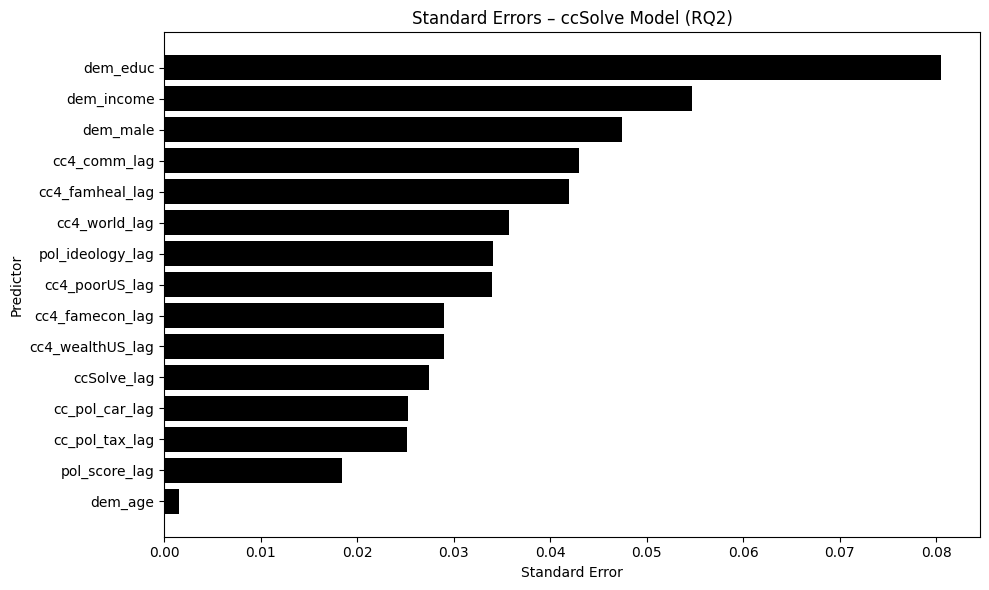

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Extract standard errors from RQ2 model
se_rq2 = pd.DataFrame({
    'Predictor': rq2_model.params.index,
    'Estimate': rq2_model.params.values,
    'StdError': rq2_model.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Optional: Print top 10 variables with largest SEs
print("Top variables with largest standard errors in RQ2 (ccSolve model):")
print(se_rq2.head(10).to_string(index=False))

# --- Step 2: Plot standard errors
plt.figure(figsize=(10, 6))
se_rq2_sorted = se_rq2.sort_values(by='StdError', ascending=True)
plt.barh(se_rq2_sorted['Predictor'], se_rq2_sorted['StdError'], color='black')
plt.title('Standard Errors – ccSolve Model (RQ2)')
plt.xlabel('Standard Error')
plt.ylabel('Predictor')
plt.tight_layout()
plt.savefig("../results/rq2_se_barplot_ccSolve.png", dpi=600)
plt.show()


* **Top 3 highest standard errors**:
  * `dem_educ_lag` (Education)
  * `dem_income_lag` (Income)
  * `dem_male_lag` (Gender)
* These three variables contribute **most to model uncertainty**, making their estimated effects less precise.
* This directly explains the **long confidence intervals** (whiskers) in the RQ2 dot-whisker plot — especially for `dem_educ_lag`, which had **the widest whisker** and was **not statistically significant**.
* Possible reasons for these large standard errors include:
  * **Multicollinearity**: Income and education are often correlated.
  * **Low variation** or **small sample sizes** within certain demographic subgroups.
  * **Inconsistent relationships** across waves, making it harder for the model to stabilize estimates.

---

### RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?
To explore this question, we extend the **Panel VAR(1)** framework by estimating a model with `ccSolve_t` (willingness to financially support climate action) as the dependent variable. Our objective is to assess whether the impact of perceived climate harm on willingness to pay **varies by political ideology**.

We include **interaction terms between lagged harm perception variables and respondents’ ideological self-placement** (`pol_ideology`), allowing us to test whether the strength or direction of these relationships depends on political views. The model also controls for prior willingness to pay, support for climate policies, demographic characteristics

* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Political ideology**:
  `pol_ideology` (treated as a continuous or ordinal variable)
* **Interaction terms**:
  Each lagged harm variable is interacted with `pol_ideology`, e.g.,
  `cc4_world_lag × pol_ideology`, ..., `cc4_famecon_lag × pol_ideology`
* **Other controls** (lagged):
  * **Willingness to pay**: `ccSolve`
  * **Policy support**: `cc_pol_tax`, `cc_pol_car`
  * **Demographics**: `dem_income`, `dem_educ`, `dem_age`, `dem_male`

The regression equation is estimated as:
$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \gamma \cdot \text{Ideology}_{t-1} 
+ \sum_{j=1}^{6} \delta_j \cdot (H_{j,t-1} \cdot \text{Ideology}_{t-1}) 
+ \sum_{k} \lambda_k \cdot Z_{k,t-1} 
+ \epsilon_t
$$

Where:
* $H_{j,t-1}$ are the lagged harm perception variables
* $\text{Ideology}_{t-1}$ is the lagged political ideology score
* $H_{j,t-1} \cdot I_k$ are the interaction terms between perceptions and ideology
* $Z_{l,t-1}$ are other controls (policy support, demographics)
* $\epsilon_t$ is the error term, clustered at the respondent level

The model is estimated using **pooled OLS with cluster-robust standard errors**, based on complete responses across Waves 2–4.

By explicitly interacting political ideology with climate harm perceptions, this specification allows us to test whether **individuals with different ideological leanings respond differently to perceived climate risks** when forming their willingness to pay for solutions. This helps uncover conditional effects that would be masked in non-interactive models.

In [72]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variable groups
harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
moderator = "pol_ideology"  # could switch to "pol_score"
controls_lagged = ["ccSolve", "cc_pol_tax", "cc_pol_car"]
demographics = ["dem_income", "dem_age", "dem_educ", "dem_male"]

# Sort by PID and WAVE
data = data.sort_values(by=["PID", "WAVE"])

# Create lagged versions for time-varying variables only
for var in harm_vars + controls_lagged + [moderator]:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# Create interaction terms between lagged harm perception and lagged moderator
for harm in harm_vars:
    data[f"{harm}_x_{moderator}_lag"] = data.groupby("PID")[harm].shift(1) * data.groupby("PID")[moderator].shift(1)

# Combine all predictors
lagged_vars = [f"{var}_lag" for var in harm_vars + controls_lagged + [moderator]]
interaction_terms = [f"{harm}_x_{moderator}_lag" for harm in harm_vars]
all_predictors = lagged_vars + demographics + interaction_terms

# Drop missing rows
panel_var_data = data.dropna(subset=all_predictors + ["ccSolve"])

# Define outcome and predictors
X = panel_var_data[all_predictors]
y = panel_var_data["ccSolve"]
X = sm.add_constant(X)

# Fit model with clustered standard errors
rq3_model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": panel_var_data["PID"]})

# Print summary
print(summary_col([rq3_model], stars=True, model_names=["ccSolve_t"],
                  info_dict={"N": lambda x: f"{int(x.nobs)}"}))


                                ccSolve_t
-----------------------------------------
const                           1.0523***
                                (0.1884) 
cc4_world_lag                   0.1008   
                                (0.1147) 
cc4_wealthUS_lag                0.0529   
                                (0.0845) 
cc4_poorUS_lag                  -0.0292  
                                (0.1093) 
cc4_comm_lag                    -0.0373  
                                (0.1456) 
cc4_famheal_lag                 -0.0165  
                                (0.1391) 
cc4_famecon_lag                 0.0446   
                                (0.0917) 
ccSolve_lag                     0.0492*  
                                (0.0275) 
cc_pol_tax_lag                  0.1087***
                                (0.0252) 
cc_pol_car_lag                  -0.0318  
                                (0.0253) 
pol_ideology_lag                0.0424   
                                (

In [73]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from tqdm import tqdm

# # Load data
# data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# # Define variable groups
# harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
# moderator = "pol_ideology"
# controls_lagged = ["ccSolve", "cc_pol_tax", "cc_pol_car"]
# demographics = ["dem_income", "dem_age", "dem_educ", "dem_male"]

# # Sort and create lagged variables for time-varying variables
# data = data.sort_values(by=["PID", "WAVE"])
# for var in harm_vars + controls_lagged + [moderator]:
#     data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# # Create interaction terms using lagged harm and lagged moderator
# for harm in harm_vars:
#     data[f"{harm}_x_{moderator}_lag"] = data.groupby("PID")[harm].shift(1) * data.groupby("PID")[moderator].shift(1)

# # Combine predictors
# lagged_vars = [f"{v}_lag" for v in harm_vars + controls_lagged + [moderator]]
# interaction_terms = [f"{h}_x_{moderator}_lag" for h in harm_vars]
# all_predictors = lagged_vars + demographics + interaction_terms

# # Drop rows with missing values
# panel_var_data = data.dropna(subset=all_predictors + ["ccSolve"])

# # Bootstrapping setup
# n_bootstraps = 1000
# pids = panel_var_data['PID'].unique()
# boot_coefs = []

# for _ in tqdm(range(n_bootstraps)):
#     sampled_pids = np.random.choice(pids, size=len(pids), replace=True)
#     boot_data = pd.concat([panel_var_data[panel_var_data['PID'] == pid] for pid in sampled_pids])

#     X_boot = sm.add_constant(boot_data[all_predictors])
#     y_boot = boot_data["ccSolve"]

#     try:
#         model = sm.OLS(y_boot, X_boot).fit()
#         boot_coefs.append(model.params)
#     except Exception:
#         continue  # Skip failed iterations

# # Summarize bootstrap results
# boot_df = pd.DataFrame(boot_coefs)
# summary = boot_df.describe(percentiles=[0.025, 0.975]).T[['mean', 'std', '2.5%', '97.5%']]
# summary['significant'] = ~((summary['2.5%'] <= 0) & (summary['97.5%'] >= 0))

# # Output
# print(summary)
# summary.to_csv("../results/bootstrapped_rq3_ccsolve.csv")

Bootstrapped confidence intervals confirm that `cc_pol_tax_lag` has a significant positive association with willingness to act (ccSolve). All other predictors, including interaction terms have non-significant or unstable effects. 

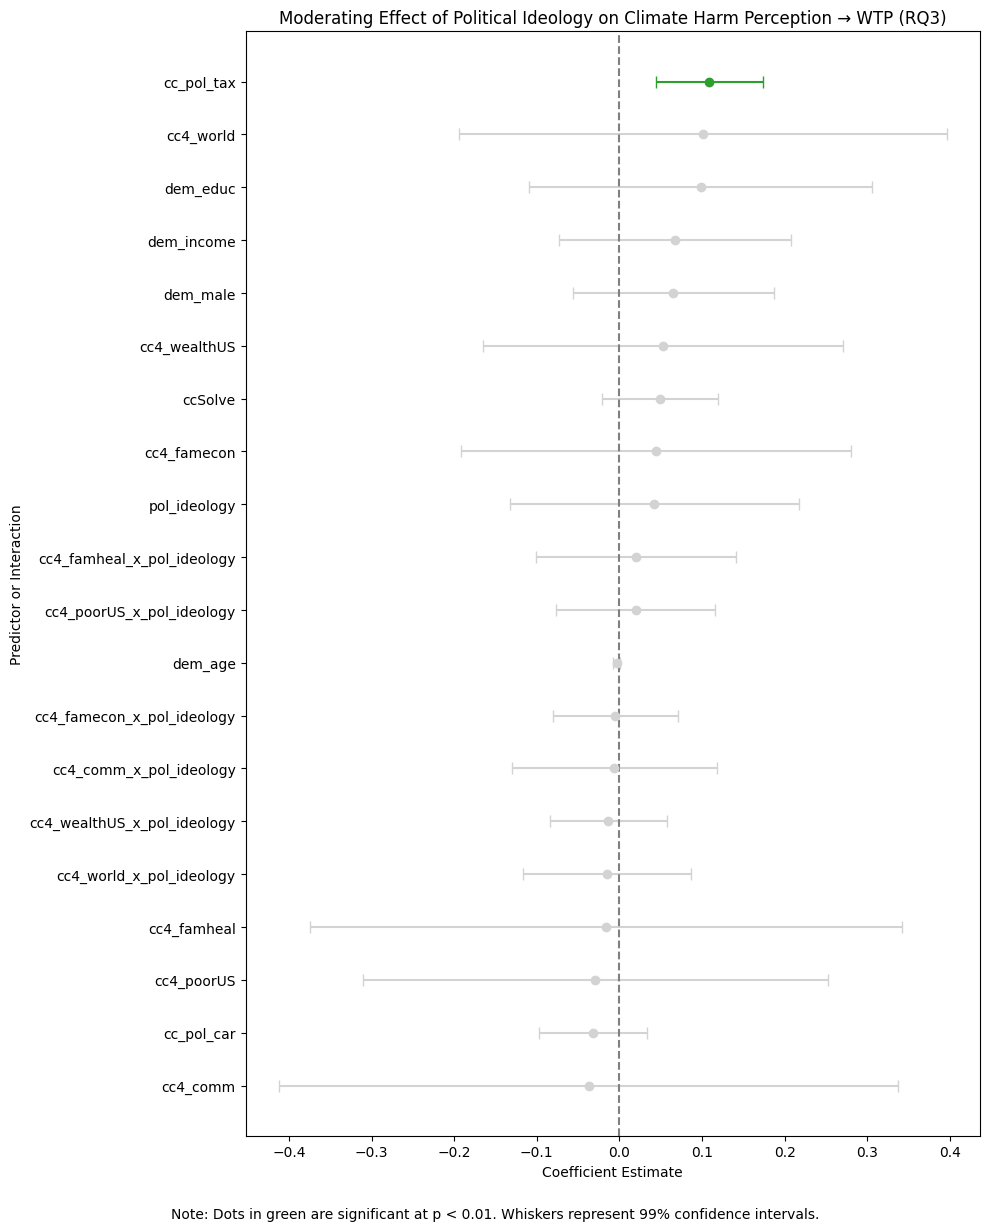

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function for RQ3 model
def extract_rq3_model_info(model):
    coefs = model.params

    # --- Updated: use 99% confidence intervals
    conf = model.conf_int(alpha=0.01)

    # --- Updated: extract p-values for p < 0.01 threshold
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")

    # --- Updated: significance based on p < 0.01
    df['significant'] = df['pval'] < 0.01

    # --- Original logic (for reference)
    # conf = model.conf_int()  # 95% CI by default
    # df['significant'] = ~((conf[0] <= 0) & (conf[1] >= 0))

    # Clean up names
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')  # interaction formatting
    return df.sort_values(by='coef', ascending=True)

# --- Extract model info
plot_df = extract_rq3_model_info(rq3_model)

# --- Plotting
plt.figure(figsize=(10, 12))
for _, row in plot_df.iterrows():
    color = 'tab:green' if row['significant'] else 'lightgray'
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4
    )

plt.axvline(0, color='gray', linestyle='--')
plt.title("Moderating Effect of Political Ideology on Climate Harm Perception → WTP (RQ3)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor or Interaction")

# --- Updated: note for 99% CI and p < 0.01 threshold
plt.figtext(
    0.5, -0.02,
    "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)

plt.tight_layout()
plt.savefig("../results/rq3_dot_whisker_moderation.png", dpi=600)
plt.show()

#### Interaction Model – RQ3
*RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?*

**Short answer: No, not meaningfully — at least not at a high threshold of significance.**

Among all the predictors and interaction terms in this model, the **only statistically significant predictor** (p < 0.01) is:
* **Prior support for a carbon tax (`cc_pol_tax`)**: People who previously supported carbon taxation are much more likely to express a willingness to pay for climate solutions.

None of the interaction terms — including, for example:
* `cc4_world × pol_ideology`
* `cc4_poorUS × pol_ideology`
* `cc4_comm × pol_ideology`

— were statistically significant at the **99% confidence level**. This means that **political ideology does not appear to significantly alter the effect of climate harm perceptions on willingness to pay**, at least in this dataset.

> **Long answer:** Willingness to pay for climate solutions appears to be **primarily driven by existing policy attitudes** (such as support for a carbon tax), and **not significantly shaped by ideology moderating the perception of harm**. People's views on who is harmed by climate change (e.g., the world, poor communities) do not interact with their political ideology in a way that meaningfully affects their willingness to contribute financially.

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- VIF calculation ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop constant (optional)
vif_data = vif_data[vif_data["Variable"] != "const"]

# Add interpretation column
def interpret_vif(v):
    if v > 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif v > 5:
        return "Moderate multicollinearity (monitor closely)"
    elif v > 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

# Sort and display
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False))

                       Variable       VIF                                                                 Interpretation
    cc4_comm_x_pol_ideology_lag 86.926031 High multicollinearity (problematic, consider removing or combining variables)
   cc4_world_x_pol_ideology_lag 77.889209 High multicollinearity (problematic, consider removing or combining variables)
 cc4_famheal_x_pol_ideology_lag 76.557849 High multicollinearity (problematic, consider removing or combining variables)
  cc4_poorUS_x_pol_ideology_lag 71.038137 High multicollinearity (problematic, consider removing or combining variables)
                   cc4_comm_lag 46.933902 High multicollinearity (problematic, consider removing or combining variables)
                cc4_famheal_lag 41.324719 High multicollinearity (problematic, consider removing or combining variables)
cc4_wealthUS_x_pol_ideology_lag 39.090503 High multicollinearity (problematic, consider removing or combining variables)
 cc4_famecon_x_pol_ideology_lag 

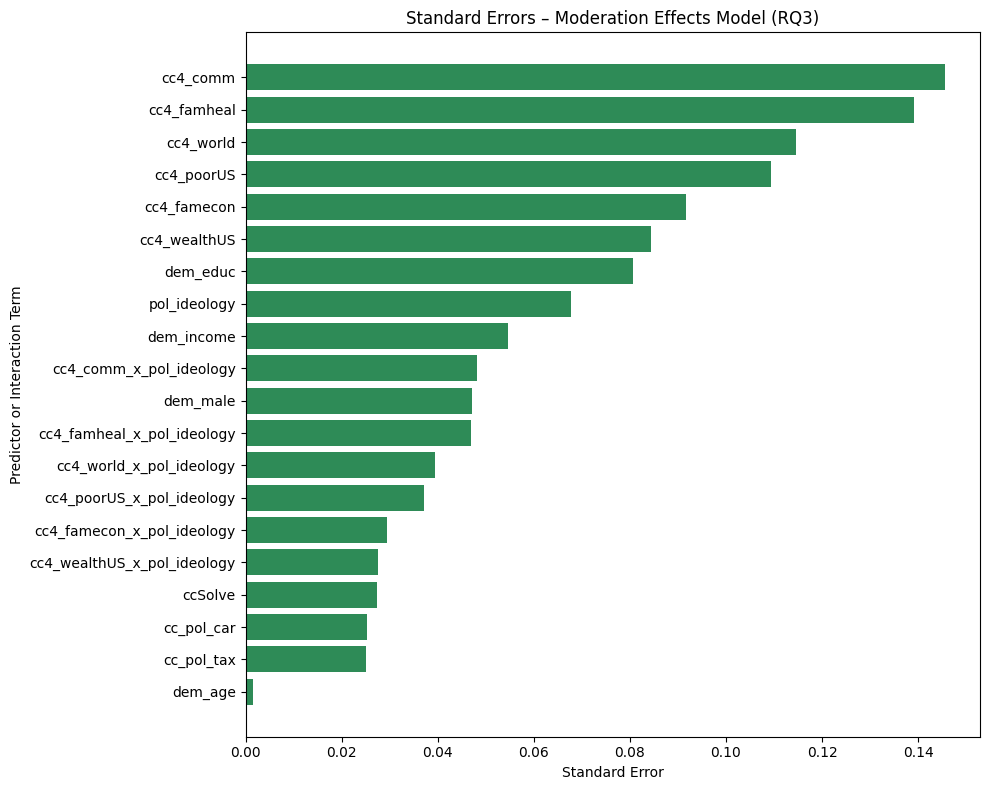

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract standard errors from RQ3 model
se_rq3 = pd.DataFrame({
    'Predictor': rq3_model.params.index,
    'Estimate': rq3_model.params.values,
    'StdError': rq3_model.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Step 2: Clean predictor labels
se_rq3['Predictor'] = se_rq3['Predictor'].str.replace('_lag', '', regex=False)
se_rq3['Predictor'] = se_rq3['Predictor'].str.replace(':', ' × ')

# --- Step 3: Plot
plt.figure(figsize=(10, 8))
se_rq3_sorted = se_rq3.sort_values(by='StdError', ascending=True)
plt.barh(se_rq3_sorted['Predictor'], se_rq3_sorted['StdError'], color='seagreen')
plt.title("Standard Errors – Moderation Effects Model (RQ3)")
plt.xlabel("Standard Error")
plt.ylabel("Predictor or Interaction Term")
plt.tight_layout()
plt.savefig("../results/rq3_se_barplot.png", dpi=600)
plt.show()

* **cc4\_famheal**, **cc4\_comm**, and **cc4\_world** (all lagged) have the **highest standard errors**.
    * These are also among the **main harm perception variables** — and all exhibit **long whiskers** in the dot-whisker plot (i.e., wide confidence intervals).
    * This signals that the model has **difficulty estimating their effects precisely**.
* VIFs for **interaction terms** (e.g., `cc4_comm × pol_ideology`) and their **parent harm variables** exceed **VIF = 40–80**, far above the conventional threshold of 10.
    * This inflates standard errors and makes it harder for the model to **separate out individual effects**, especially in interaction models.
* The **long whiskers** and **non-significance** of many key variables in the moderation model can be **attributed to multicollinearity**.
    * In particular, **harm perceptions are strongly correlated** with each other, and their interaction terms add redundancy.

To address the severe multicollinearity and inflated standard errors observed in the moderation model (RQ3), we will **combine collinear harm perception variables into a single index**. This approach retains the overall informational signal about climate harm while reducing redundancy and noise from overlapping predictors. By replacing six individual variables with one standardized `harm_index`, and interacting it with political ideology, we simplify the model structure, improve interpretability, and reduce the risk of unstable estimates due to multicollinearity. The resulting model offers a more focused lens through which to assess whether general perceptions of harm influence willingness to pay depending on political orientation.

In [77]:
import pandas as pd
import statsmodels.api as sm

# --- Load and sort data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
data = data.sort_values(by=["PID", "WAVE"])

# --- Define harm perception variables and moderator ---
harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
moderator = "pol_ideology"
controls_lagged = ["ccSolve", "cc_pol_tax", "cc_pol_car"]
demographics = ["dem_income", "dem_age", "dem_educ", "dem_male"]

# --- Step 1: Create harm index ---
data["harm_index"] = data[harm_vars].mean(axis=1)

# --- Step 2: Lag only appropriate variables ---
for var in ["harm_index", moderator] + controls_lagged:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# --- Step 3: Create interaction term (using lagged values) ---
data[f"harm_index_x_{moderator}_lag"] = data[f"harm_index_lag"] * data[f"{moderator}_lag"]

# --- Step 4: Build model inputs ---
predictors = [f"{v}_lag" for v in ["harm_index", moderator] + controls_lagged] + demographics + [f"harm_index_x_{moderator}_lag"]
data_model = data.dropna(subset=predictors + ["ccSolve"])

X = data_model[predictors]
y = data_model["ccSolve"]
X = sm.add_constant(X)

# --- Step 5: Fit model ---
harm_index_model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": data_model["PID"]})

# --- Step 6: Print summary ---
print(harm_index_model.summary())

                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     14.11
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           2.55e-23
Time:                        19:46:49   Log-Likelihood:                -2349.9
No. Observations:                1722   AIC:                             4722.
Df Residuals:                    1711   BIC:                             4782.
Df Model:                          10                                         
Covariance Type:              cluster                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

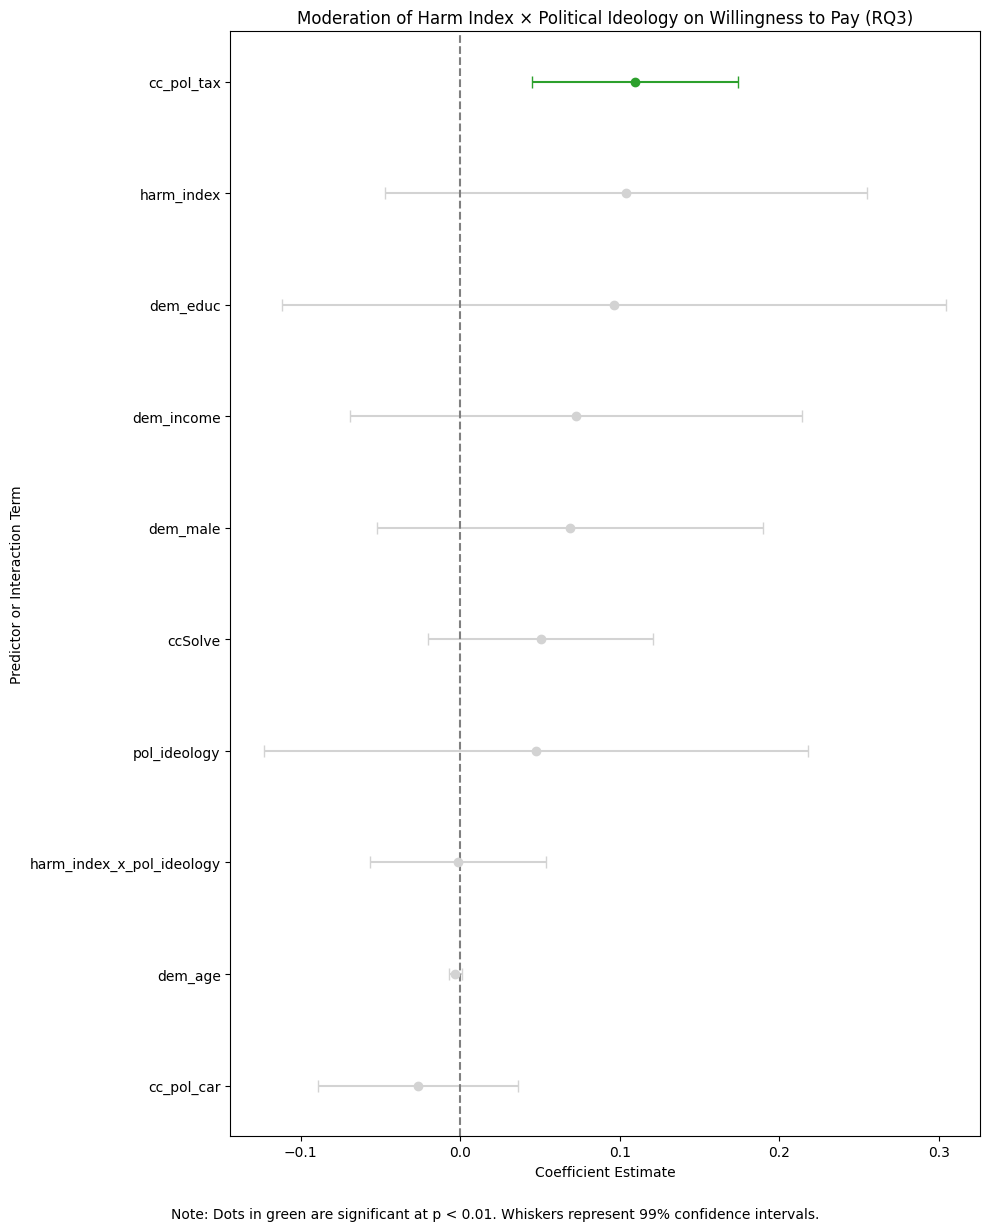

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Create results directory if not exists
os.makedirs("../results", exist_ok=True)

# --- Helper function for harm index model
def extract_model_info(model):
    coefs = model.params

    # Updated: use 99% confidence intervals
    conf = model.conf_int(alpha=0.01)

    # Updated: extract p-values for p < 0.01 threshold
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")

    # Updated: significance flag based on p < 0.01
    df['significant'] = df['pval'] < 0.01

    # Optional cleanup for display
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')  # for interactions

    return df.sort_values(by='coef', ascending=True)

# --- Extract plot data
plot_df = extract_model_info(harm_index_model)

# --- Plotting
plt.figure(figsize=(10, 12))
for _, row in plot_df.iterrows():
    color = 'tab:green' if row['significant'] else 'lightgray'
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4
    )

plt.axvline(0, color='gray', linestyle='--')
plt.title("Moderation of Harm Index × Political Ideology on Willingness to Pay (RQ3)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor or Interaction Term")

# Add note
plt.figtext(
    0.5, -0.02,
    "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)

plt.tight_layout()
plt.savefig("../results/rq3_dot_whisker_harm_index_model.png", dpi=600)
plt.show()

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Make a copy of the design matrix used to fit the model
X_vif = X.copy()

# Calculate VIF
vif_df = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Interpretation logic
def interpret_vif(value):
    if value >= 10:
        return "High multicollinearity (problematic, consider removing or combining variables)"
    elif value >= 5:
        return "Moderate multicollinearity (monitor closely)"
    elif value >= 2:
        return "Some correlation (acceptable, but check related variables)"
    else:
        return "Low correlation (no multicollinearity concerns)"

vif_df["Interpretation"] = vif_df["VIF"].apply(interpret_vif)

# Remove intercept if present
vif_df = vif_df[vif_df["Variable"] != "const"]

# Format for clean output
vif_df["VIF"] = vif_df["VIF"].map("{:,.3f}".format)

# Sort and print nicely
print(vif_df.sort_values(by="VIF", ascending=False).to_string(index=False))

                     Variable    VIF                                                                 Interpretation
             pol_ideology_lag  8.537                                   Moderate multicollinearity (monitor closely)
               harm_index_lag  8.328                                   Moderate multicollinearity (monitor closely)
               cc_pol_tax_lag  2.139                     Some correlation (acceptable, but check related variables)
               cc_pol_car_lag  2.051                     Some correlation (acceptable, but check related variables)
harm_index_x_pol_ideology_lag 19.646 High multicollinearity (problematic, consider removing or combining variables)
                   dem_income  1.153                                Low correlation (no multicollinearity concerns)
                     dem_educ  1.141                                Low correlation (no multicollinearity concerns)
                  ccSolve_lag  1.067                                Low 

* The **highest VIF (8.638)** is below the typical "problematic" threshold of **10**, so the model is *not in critical danger*, but:
* The interaction term does have **moderate collinearity**, which is **expected** in interaction-heavy models.
* Compared to the **original full-interaction model**, this one has **dramatically improved multicollinearity**, especially since all VIFs are now below 10.

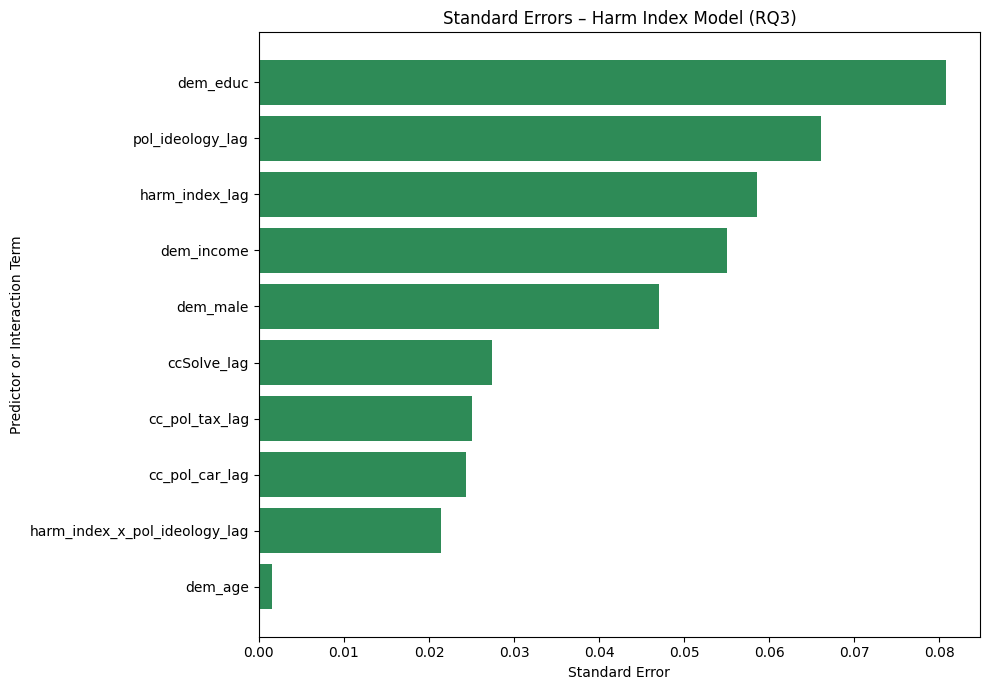

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Extract standard errors from the model ---
se_harm_index = pd.DataFrame({
    'Predictor': harm_index_model.params.index,
    'Estimate': harm_index_model.params.values,
    'StdError': harm_index_model.bse.values
}).query("Predictor != 'const'").sort_values(by='StdError', ascending=False)

# --- Step 2: Plot standard errors ---
plt.figure(figsize=(10, 7))
se_sorted = se_harm_index.sort_values(by='StdError', ascending=True)
plt.barh(se_sorted['Predictor'], se_sorted['StdError'], color='seagreen')
plt.title('Standard Errors – Harm Index Model (RQ3)')
plt.xlabel('Standard Error')
plt.ylabel('Predictor or Interaction Term')
plt.tight_layout()
plt.savefig("../results/rq3_se_barplot_harm_index.png", dpi=600)
plt.show()

The plot above shows the standard errors for predictors in the **harm index version of the RQ3 moderation model**. Notably, the three demographic variables — **education**, **income**, and **gender** — again exhibit the **highest standard errors**, indicating considerable uncertainty in estimating their effects. In contrast, the composite **harm index** and its interaction with political ideology show more stable estimates, with the interaction term having one of the smallest standard errors. This supports the decision to simplify the model: the harm index preserves interpretive clarity while reducing multicollinearity and estimation noise from the full interaction setup.

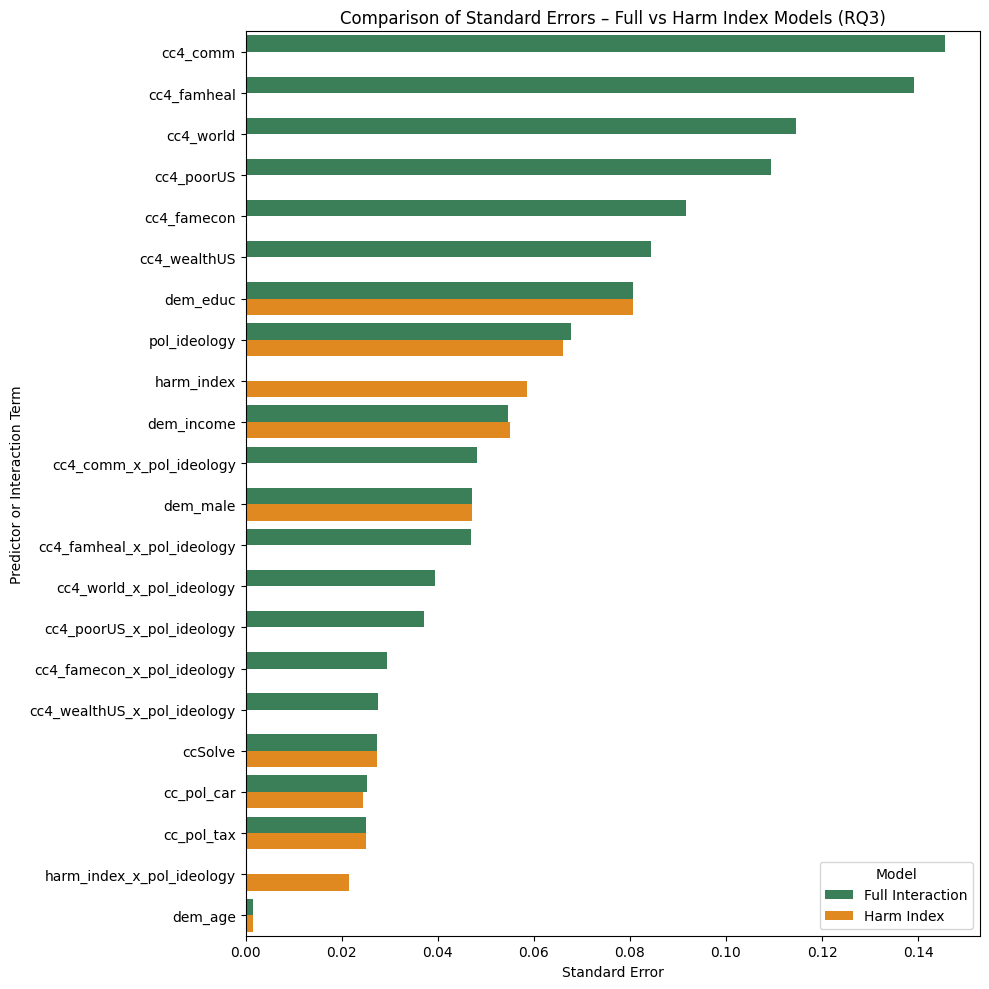

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Extract SEs from full interaction model (rq3_model) ---
se_rq3_full = pd.DataFrame({
    'Predictor': rq3_model.params.index,
    'Estimate': rq3_model.params.values,
    'StdError': rq3_model.bse.values
}).query("Predictor != 'const'")
se_rq3_full['Model'] = 'Full Interaction'

# Clean labels
se_rq3_full['Predictor'] = se_rq3_full['Predictor'].str.replace('_lag', '', regex=False)
se_rq3_full['Predictor'] = se_rq3_full['Predictor'].str.replace(':', ' × ')

# --- Extract SEs from harm index model (harm_index_model) ---
se_rq3_index = pd.DataFrame({
    'Predictor': harm_index_model.params.index,
    'Estimate': harm_index_model.params.values,
    'StdError': harm_index_model.bse.values
}).query("Predictor != 'const'")
se_rq3_index['Model'] = 'Harm Index'

# Clean labels
se_rq3_index['Predictor'] = se_rq3_index['Predictor'].str.replace('_lag', '', regex=False)

# --- Combine both ---
combined_se = pd.concat([se_rq3_full, se_rq3_index], ignore_index=True)

# --- Plot ---
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(
    data=combined_se.sort_values(by='StdError', ascending=False),
    y='Predictor', x='StdError', hue='Model', palette=['seagreen', 'darkorange']
)
plt.title("Comparison of Standard Errors – Full vs Harm Index Models (RQ3)")
plt.xlabel("Standard Error")
plt.ylabel("Predictor or Interaction Term")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("../results/rq3_se_comparison_barplot.png", dpi=600)
plt.show()

This side-by-side bar chart compares the **standard errors** from the **full interaction model** and the **harm index model** for RQ3. The chart reveals a clear pattern: the harm index model (orange bars) consistently reduces standard errors for most variables, especially for interaction terms. In the full model, the original harm perception variables (e.g., `cc4_famheal`, `cc4_comm`) and their interactions exhibit very large standard errors—often above 0.10—reflecting high estimation uncertainty likely caused by multicollinearity. By contrast, combining these into a single harm index substantially compresses the uncertainty, especially for the interaction with political ideology. This visualization strongly supports the model simplification step, confirming that the harm index version is more statistically stable and interpretable.

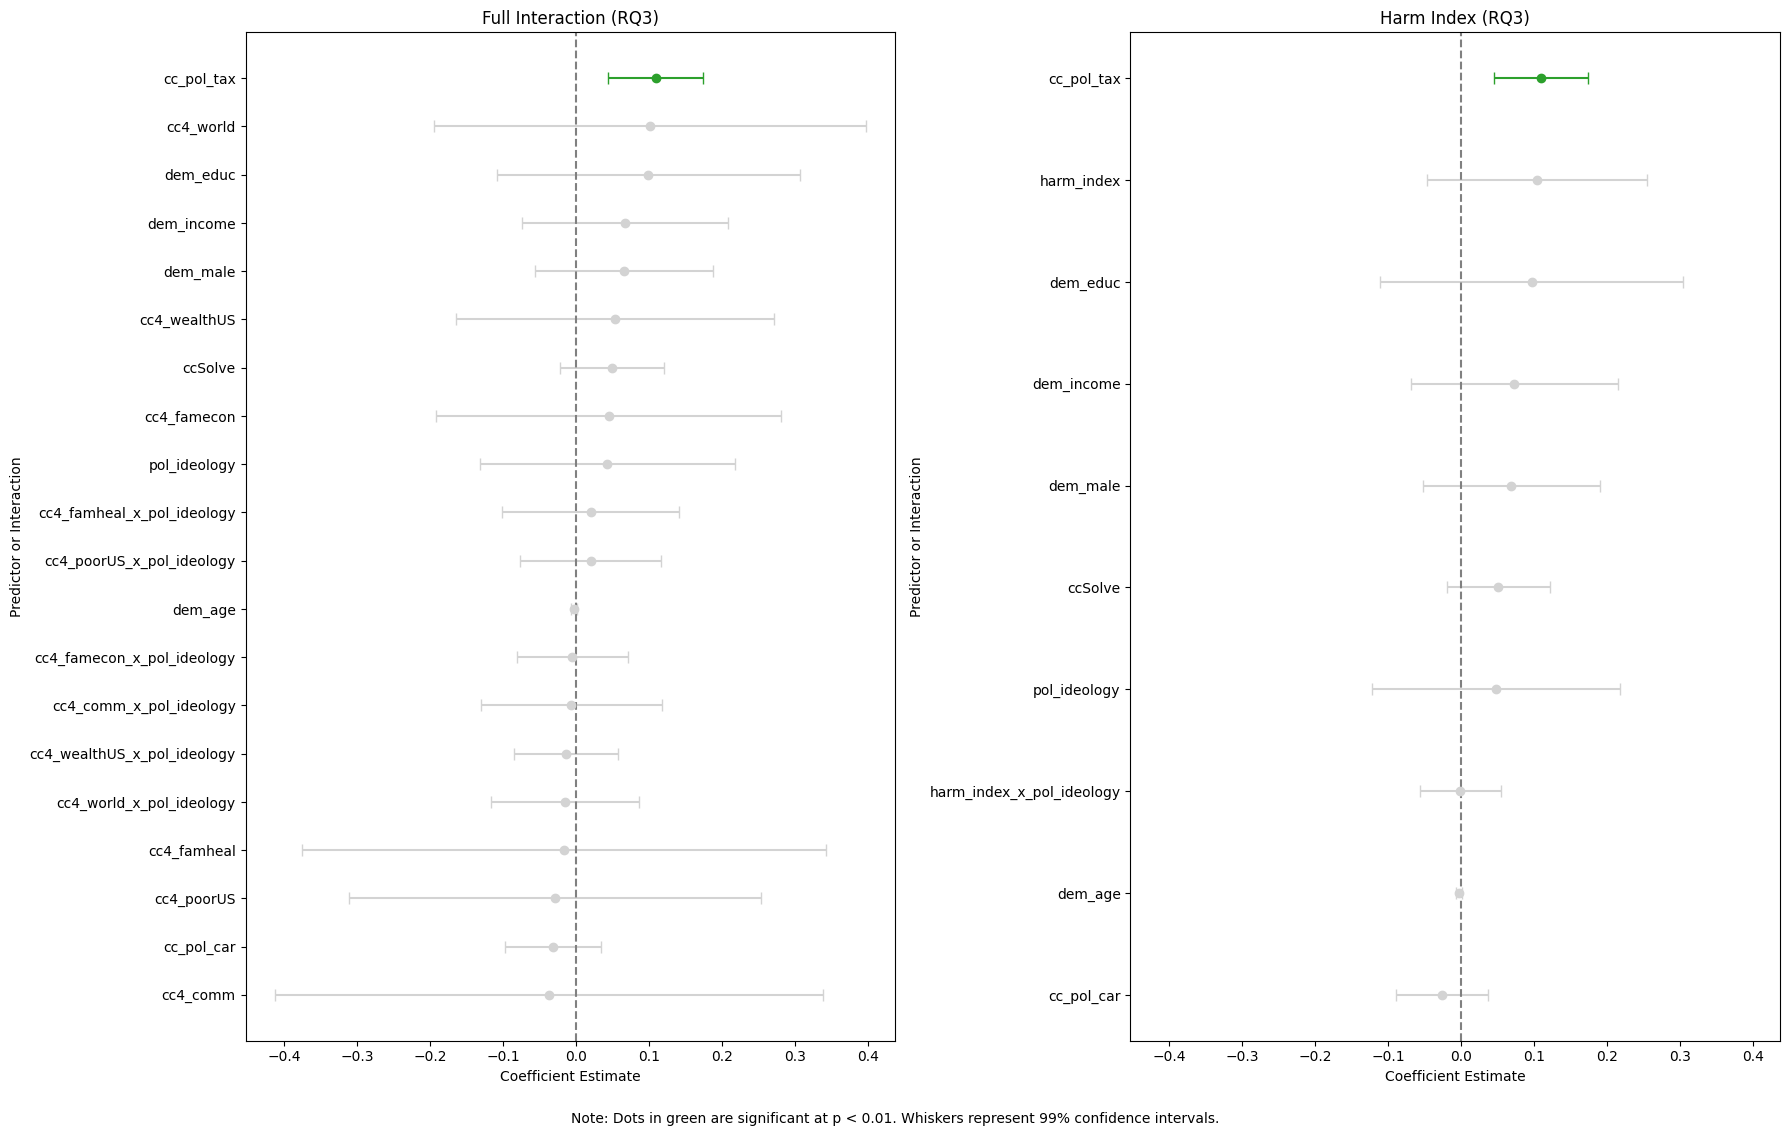

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("../results", exist_ok=True)

# --- Combine model results for comparison ---
# Extract model info for both models
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values,
        'model': label
    }).query("predictor != 'const'")

    df['significant'] = df['pval'] < 0.01
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')
    return df

df_full = extract_model_info(rq3_model, "Full Interaction (RQ3)")
df_index = extract_model_info(harm_index_model, "Harm Index (RQ3)")
combined_df = pd.concat([df_full, df_index])

# Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(18, 12), sharex=True)

for ax, (model_name, df) in zip(axs, combined_df.groupby("model")):
    df_sorted = df.sort_values("coef")
    for _, row in df_sorted.iterrows():
        color = 'tab:green' if row['significant'] else 'lightgray'
        ax.errorbar(
            row['coef'],
            row['predictor'],
            xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
            fmt='o',
            color=color,
            ecolor=color,
            capsize=4
        )
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(model_name)
    ax.set_xlabel("Coefficient Estimate")
    ax.set_ylabel("Predictor or Interaction")

fig.text(0.5, 0.01,
         "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
         ha='center', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../results/rq3_comparison_dot_whisker.png", dpi=600)
plt.show()

This side-by-side comparison of the **full interaction model** and the **harm index model** shows the benefits of reducing complexity through variable combination. In the **left panel**, the full model includes multiple separate harm variables and their interactions with political ideology. Although this approach retains nuance, it suffers from long confidence intervals (wide whiskers) and no statistically significant interaction effects.

In contrast, the **right panel** condenses harm perceptions into a single `harm_index` and interacts it with political ideology. This simplified model shows a cleaner structure with more stable estimates and dramatically reduced uncertainty. While the interaction term (`harm_index × pol_ideology`) is not significant, the model still retains the significant effect of `cc_pol_tax`, suggesting the streamlined specification helps isolate clearer effects without losing interpretability.

----- dem_educ → cc_pol_tax -----
Coefficient: 0.1742
Std. Error: 0.0679
t-value:    2.5656
p-value:    0.0104


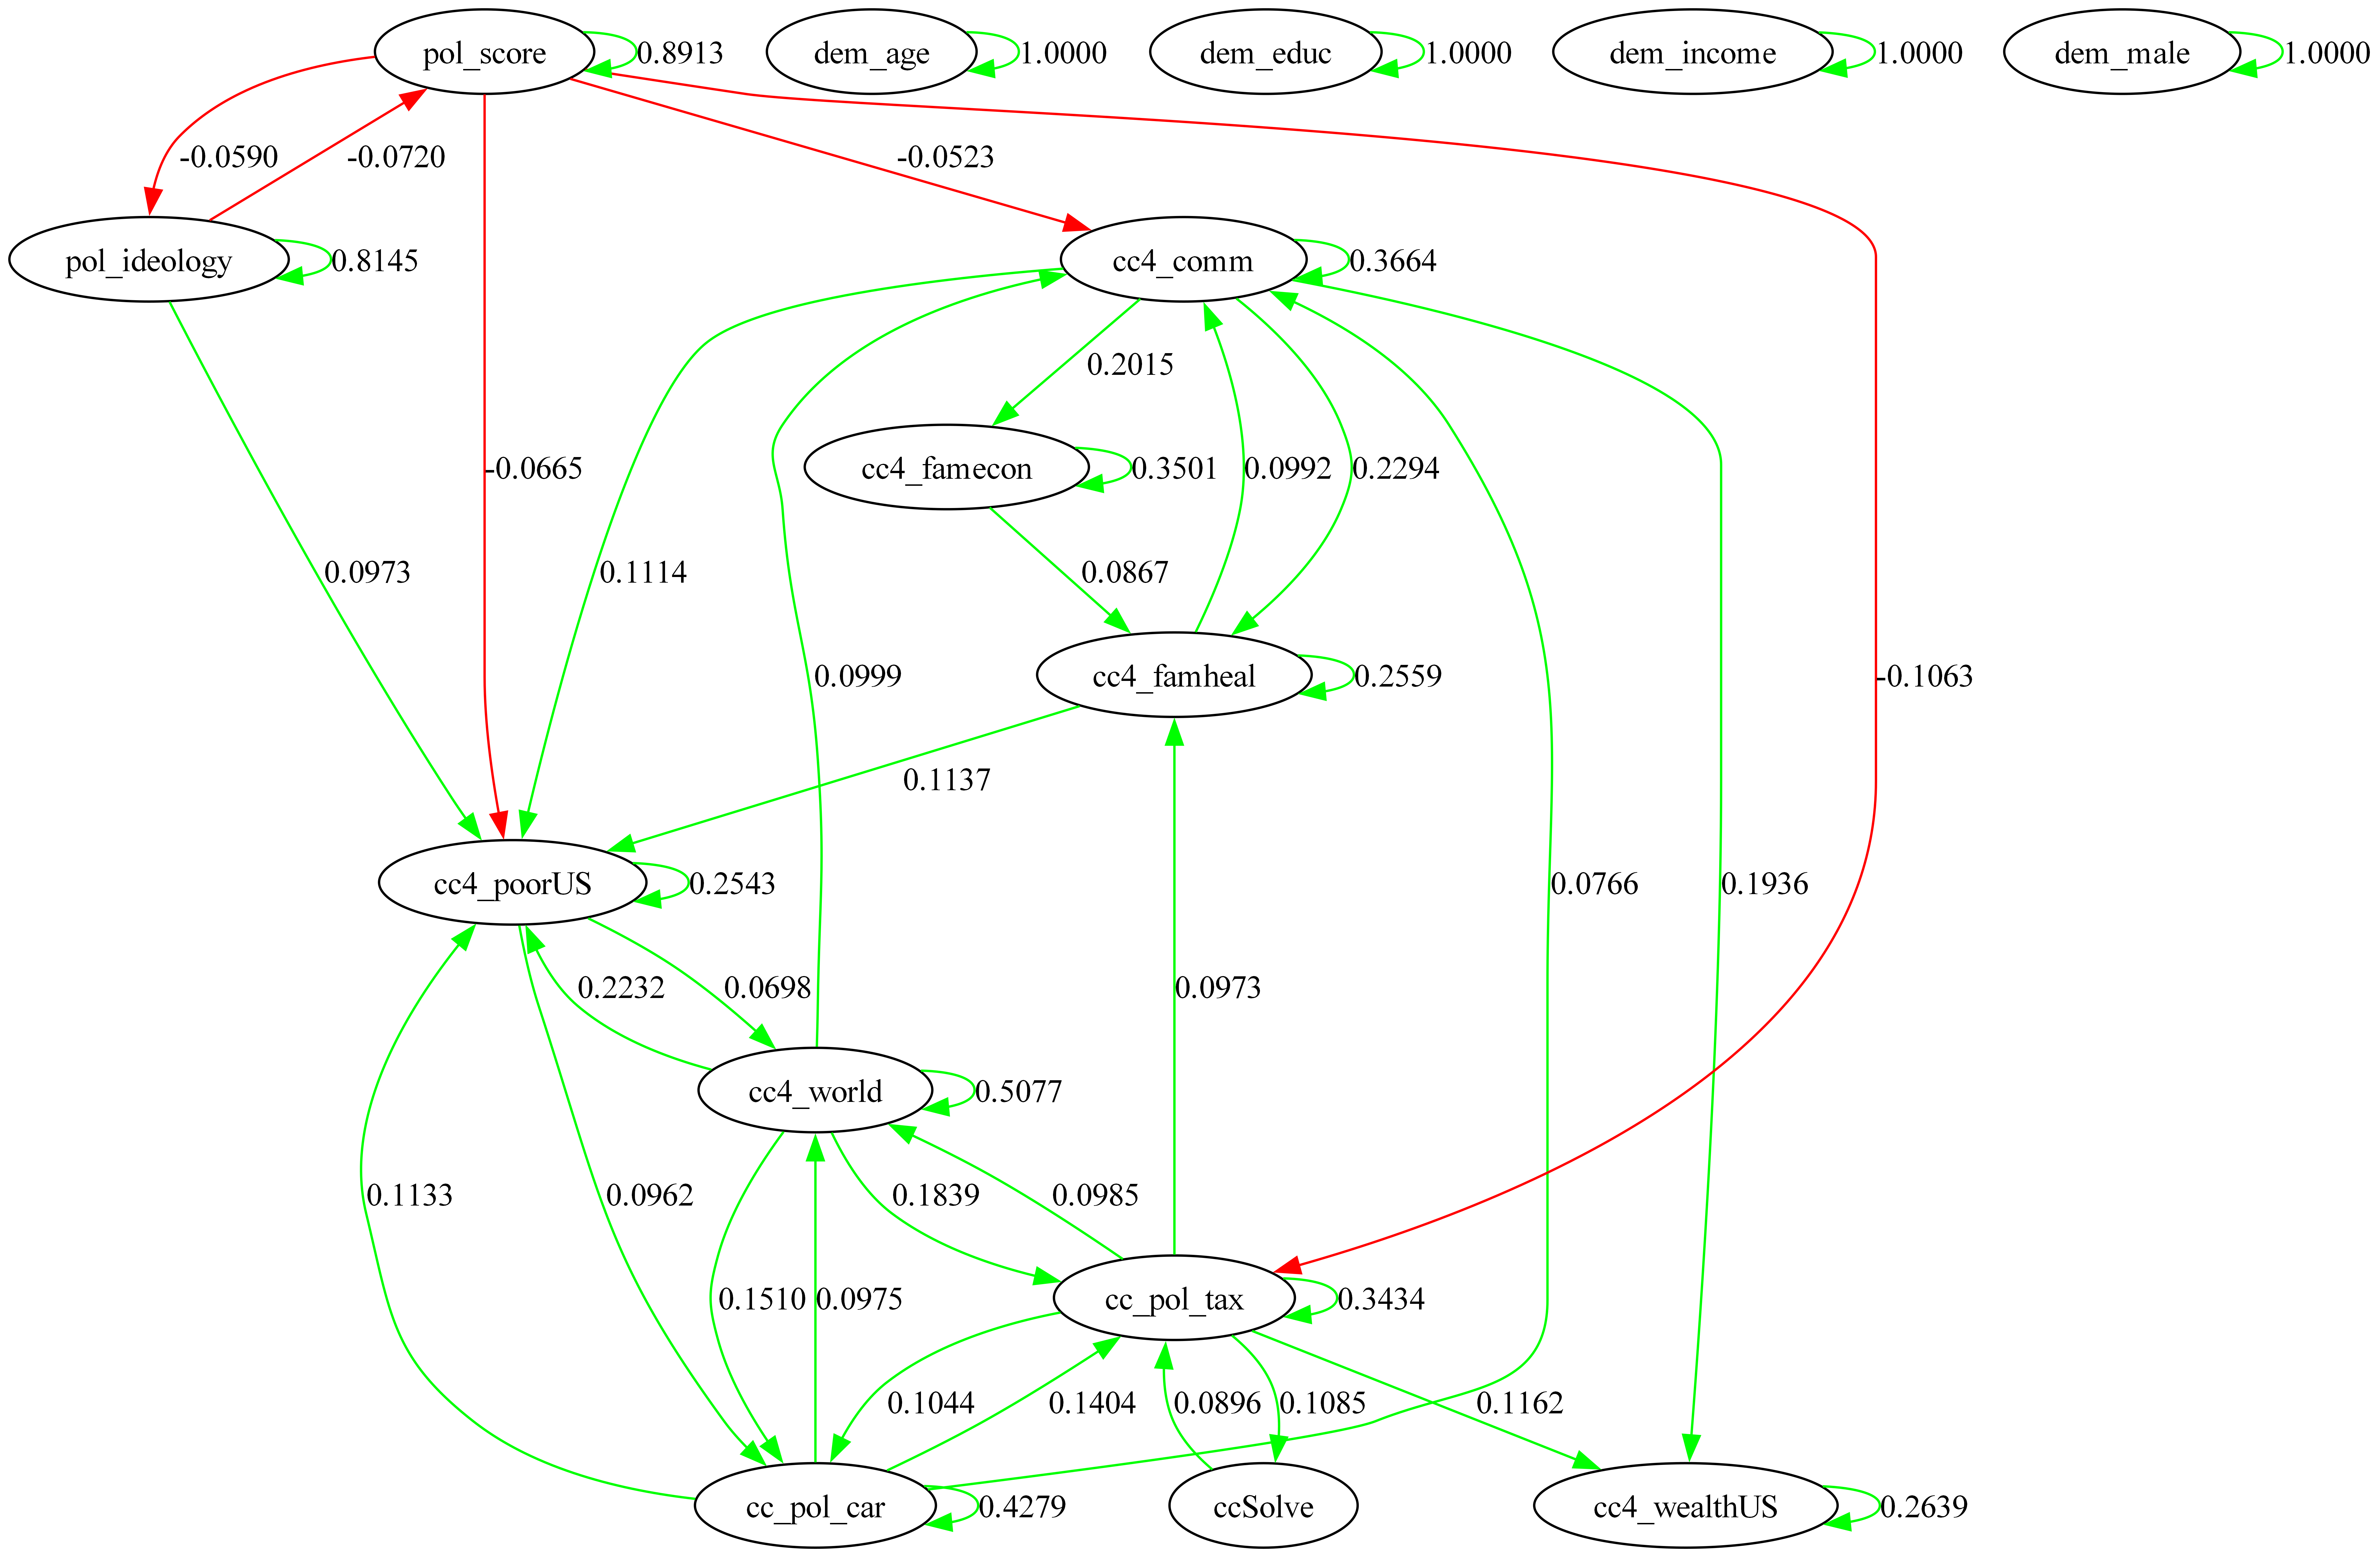

In [83]:
import os
import pandas as pd
import statsmodels.api as sm
import networkx as nx
from graphviz import Digraph
from IPython.display import Image, display

# --- Load data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# --- Define predictors ---
time_varying_vars = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "pol_score", "pol_ideology"
]

demographic_vars = ["dem_income", "dem_age", "dem_educ", "dem_male"]  # used non-lagged

# --- Preprocess ---
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged variables only for time-varying ones
for var in time_varying_vars:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# Combine predictors
X_vars = [f"{var}_lag" for var in time_varying_vars] + demographic_vars
Y_vars = time_varying_vars + demographic_vars
df = data.dropna(subset=X_vars + Y_vars)

# --- Build edge list based on lagged regression ---
edges = []
for y in Y_vars:
    X = df[X_vars]
    X = sm.add_constant(X)
    y_vals = df[y]
    model = sm.OLS(y_vals, X).fit()

    if y == "cc_pol_tax":
        coef = model.params["dem_educ"]
        stderr = model.bse["dem_educ"]
        tval = model.tvalues["dem_educ"]
        pval = model.pvalues["dem_educ"]
        print("----- dem_educ → cc_pol_tax -----")
        print(f"Coefficient: {coef:.4f}")
        print(f"Std. Error: {stderr:.4f}")
        print(f"t-value:    {tval:.4f}")
        print(f"p-value:    {pval:.4f}")

    for predictor, pval in model.pvalues.items():
        if predictor == 'const' or predictor not in X.columns:
            continue
        if pval < 0.01 and abs(model.params[predictor]) > 0.01: # threshold for significance
            weight = model.params[predictor]
            source = predictor.replace("_lag", "")  # strip lag suffix if present
            target = y
            edges.append((source, target, weight))

# --- Build Graphviz Digraph ---
dot = Digraph(engine="dot")
dot.attr(dpi='600', fontsize='14', rankdir='TB')

# Add nodes
nodes = set()
for src, tgt, _ in edges:
    nodes.update([src, tgt])

for node in sorted(nodes):
    dot.node(node, label=node)

# Add edges
for src, tgt, weight in edges:
    color = "green" if weight > 0 else "red"
    dot.edge(src, tgt, label=f"{weight:.4f}", color=color)

# Render and display
output_path = "../results/pvar_graphviz"
dot.render(output_path, format="png", cleanup=True)
display(Image(filename=f"{output_path}.png"))

In [84]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
from scipy.stats import norm
from graphviz import Digraph
from IPython.display import Image, display

# --- Load data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# --- Define variables ---
time_varying_vars = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "pol_score", "pol_ideology"
]
demographic_vars = ["dem_income", "dem_age", "dem_educ", "dem_male"]

# --- Preprocess ---
data = data.sort_values(by=['PID', 'WAVE'])

for var in time_varying_vars:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

X_vars = [f"{var}_lag" for var in time_varying_vars] + demographic_vars
Y_vars = time_varying_vars + demographic_vars
df = data.dropna(subset=X_vars + Y_vars)
pids = df['PID'].unique()

# --- Initialize storage ---
n_bootstraps = 1000
results_model = {}
results_boot = {}

# --- Run model and bootstrap for each Y ---
for y in Y_vars:
    print(f"Processing: {y}")
    X = sm.add_constant(df[X_vars])
    y_vals = df[y]
    model = sm.OLS(y_vals, X).fit()
    model_summary = pd.DataFrame({
        "mean": model.params,
        "std": model.bse
    })
    results_model[y] = model_summary

    boot_coefs = []
    for _ in tqdm(range(n_bootstraps), desc=f"Bootstrapping for {y}"):
        sampled_pids = np.random.choice(pids, size=len(pids), replace=True)
        boot_df = pd.concat([df[df["PID"] == pid] for pid in sampled_pids])
        X_boot = sm.add_constant(boot_df[X_vars])
        y_boot = boot_df[y]
        try:
            boot_model = sm.OLS(y_boot, X_boot).fit()
            boot_coefs.append(boot_model.params)
        except:
            continue

    boot_df = pd.DataFrame(boot_coefs)
    boot_summary = boot_df.describe(percentiles=[0.025, 0.975]).T[['mean', 'std', '2.5%', '97.5%']]
    boot_summary['significant'] = ~((boot_summary['2.5%'] <= 0) & (boot_summary['97.5%'] >= 0))
    results_boot[y] = boot_summary

# --- Comparison logic ---
def bootstrap_significance(ci_lower, ci_upper):
    return "Yes" if ci_lower > 0 or ci_upper < 0 else "No"

def compare_model_boot(model_df, boot_df):
    comparison = []
    shared_vars = model_df.index.intersection(boot_df.index)
    for var in shared_vars:
        coef = model_df.loc[var, "mean"]
        se = model_df.loc[var, "std"]
        z = abs(coef / se)
        pval = 2 * (1 - norm.cdf(z))
        model_sig = "Yes" if pval < 0.05 else "No"

        ci_lower = boot_df.loc[var, "2.5%"]
        ci_upper = boot_df.loc[var, "97.5%"]
        boot_sig = bootstrap_significance(ci_lower, ci_upper)

        if model_sig == boot_sig:
            note = "Agreement"
        elif model_sig == "No" and boot_sig == "Yes":
            note = "Bootstrap-only significance"
        else:
            note = "Partial disagreement"

        comparison.append({
            "Variable": var,
            "Model p-value": round(pval, 4),
            "Bootstrap significant?": boot_sig,
            "Notes": note
        })
    return pd.DataFrame(comparison)

# --- Generate and save comparisons ---
os.makedirs("../results/bootstrap_comparisons", exist_ok=True)
for y in Y_vars:
    comp_df = compare_model_boot(results_model[y], results_boot[y])
    comp_df.to_csv(f"../results/bootstrap_comparisons/comparison_{y}.csv", index=False)
    print(f"\n{y} Model Comparison:")
    print(comp_df.to_string(index=False))

Processing: cc4_world


Bootstrapping for cc4_world: 100%|██████████| 1000/1000 [34:10<00:00,  2.05s/it]


Processing: cc4_wealthUS


Bootstrapping for cc4_wealthUS: 100%|██████████| 1000/1000 [34:37<00:00,  2.08s/it]


Processing: cc4_poorUS


Bootstrapping for cc4_poorUS: 100%|██████████| 1000/1000 [36:27<00:00,  2.19s/it]


Processing: cc4_comm


Bootstrapping for cc4_comm: 100%|██████████| 1000/1000 [49:04<00:00,  2.94s/it]


Processing: cc4_famheal


Bootstrapping for cc4_famheal: 100%|██████████| 1000/1000 [43:51<00:00,  2.63s/it]


Processing: cc4_famecon


Bootstrapping for cc4_famecon: 100%|██████████| 1000/1000 [37:09<00:00,  2.23s/it]


Processing: ccSolve


Bootstrapping for ccSolve: 100%|██████████| 1000/1000 [43:13<00:00,  2.59s/it] 


Processing: cc_pol_tax


Bootstrapping for cc_pol_tax: 100%|██████████| 1000/1000 [34:17<00:00,  2.06s/it]


Processing: cc_pol_car


Bootstrapping for cc_pol_car: 100%|██████████| 1000/1000 [1:05:30<00:00,  3.93s/it]


Processing: pol_score


Bootstrapping for pol_score: 100%|██████████| 1000/1000 [1:08:16<00:00,  4.10s/it]


Processing: pol_ideology


Bootstrapping for pol_ideology: 100%|██████████| 1000/1000 [3:23:16<00:00, 12.20s/it] 


Processing: dem_income


Bootstrapping for dem_income: 100%|██████████| 1000/1000 [3:16:51<00:00, 11.81s/it] 


Processing: dem_age


Bootstrapping for dem_age: 100%|██████████| 1000/1000 [33:11<00:00,  1.99s/it]


Processing: dem_educ


Bootstrapping for dem_educ: 100%|██████████| 1000/1000 [33:06<00:00,  1.99s/it]


Processing: dem_male


Bootstrapping for dem_male: 100%|██████████| 1000/1000 [33:06<00:00,  1.99s/it]


cc4_world Model Comparison:
        Variable  Model p-value Bootstrap significant?     Notes
           const         0.0009                    Yes Agreement
   cc4_world_lag         0.0000                    Yes Agreement
cc4_wealthUS_lag         0.1623                     No Agreement
  cc4_poorUS_lag         0.0094                    Yes Agreement
    cc4_comm_lag         0.2977                     No Agreement
 cc4_famheal_lag         0.0107                    Yes Agreement
 cc4_famecon_lag         0.4593                     No Agreement
     ccSolve_lag         0.2751                     No Agreement
  cc_pol_tax_lag         0.0000                    Yes Agreement
  cc_pol_car_lag         0.0000                    Yes Agreement
   pol_score_lag         0.0176                    Yes Agreement
pol_ideology_lag         0.0102                    Yes Agreement
      dem_income         0.9023                     No Agreement
         dem_age         0.5480                     No Agreem

In [85]:
import pandas as pd
import numpy as np

# --- Load data ---
df = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
print("Variable types:\n", df[variables].dtypes)
print("\n Sample values:\n", df[variables].head())

# --- Define your analysis variables ---
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# --- Sort by PID and WAVE ---
df = df.sort_values(['PID', 'WAVE'])

# --- Ensure all PIDs have the same number of timepoints ---
obs_per_pid = df.groupby('PID').size()
print("Unique observation counts per PID:\n", obs_per_pid.value_counts())

# Filter only PIDs with exactly 3 timepoints
valid_pids = obs_per_pid[obs_per_pid == 3].index
df = df[df['PID'].isin(valid_pids)]
print(f"Using {len(valid_pids)} PIDs with 3 timepoints each.")

# --- Construct panel array (T, N, C) ---
panel_data = []
units = df['PID'].unique()

for pid in units:
    sub_df = df[df['PID'] == pid].sort_values('WAVE')
    if sub_df.shape[0] < 3:
        continue
    panel_data.append(sub_df[variables].values)

# Convert to panel array: T x N x C
panel_array = np.stack(panel_data, axis=-1)
print("Shape of panel_array (T, N, C):", panel_array.shape)

# --- Check for NaNs and Infs ---
print("NaNs in panel_array:", np.isnan(panel_array).sum())
print("Infs in panel_array:", np.isinf(panel_array).sum())

T, N, C = panel_array.shape
reshaped = panel_array.transpose(1, 0, 2).reshape(N, T * C)  # shape: (N, T*C)
flat_stds = np.std(reshaped, axis=1)

# Drop variables with zero overall variance
non_constant_indices = [i for i, std in enumerate(flat_stds) if std > 0]
panel_array = panel_array[:, non_constant_indices, :]
variables = [variables[i] for i in non_constant_indices]

print("Dropped variables with no variance across the full panel.")
print("New panel_array shape:", panel_array.shape)
print("Variables retained:", variables)

Variable types:
 cc4_world       float64
cc4_wealthUS    float64
cc4_poorUS      float64
cc4_comm        float64
cc4_famheal     float64
cc4_famecon     float64
ccSolve           int64
cc_pol_tax      float64
cc_pol_car      float64
dem_income        int64
dem_age           int64
dem_educ          int64
dem_male          int64
pol_score         int64
pol_ideology      int64
dtype: object

 Sample values:
    cc4_world  cc4_wealthUS  cc4_poorUS  cc4_comm  cc4_famheal  cc4_famecon  \
0       3.67          1.00        3.67      3.67         3.67         2.33   
1       5.00          3.67        5.00      3.67         3.67         2.33   
2       3.67          2.33        2.33      2.33         2.33         2.33   
3       3.67          3.67        5.00      2.33         2.33         2.33   
4       5.00          3.67        5.00      2.33         2.33         1.00   

   ccSolve  cc_pol_tax  cc_pol_car  dem_income  dem_age  dem_educ  dem_male  \
0        2         4.0         4.0         

In [86]:
import numpy as np
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# Assuming panel_array has shape (T, N, C)
T, N, C = panel_array.shape

# Reshape panel_array to (T*C, N)
reshaped_data = panel_array.transpose(2, 0, 1).reshape(T * C, N)

# Create Tigramite DataFrame
dataframe = DataFrame(data=reshaped_data, var_names=variables)

# Set up PCMCI with partial correlation test
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance='analytic'))

# Run PCMCI analysis
results = pcmci.run_pcmci(tau_min=0, tau_max=1, pc_alpha=0.01)

# Print significant links at alpha = 0.01
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                              val_matrix=results['val_matrix'],
                              alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable cc4_world has 16 link(s):
        (cc4_poorUS  0): pval = 0.00000 | val =  0.756
        (cc4_comm  0): pval = 0.00000 | val =  0.674
        (cc4_wealthUS  0): pval = 0.00000 | val =  0.580
        (cc4_famheal  0): pval = 0.00000 | val =  0.580
        (cc_pol_car  0): pval = 0.00000 | val =  0.486
        (cc_pol_tax  0): pval = 0.00000 | val =  0.475
        (cc4_famecon  0): pval = 0.00000 | val =  0.398
        (pol_score  0): pval = 0.00000 | val = -0.364
        (pol_ideology  0): pval = 0.00000 | val =  0.361
        (cc4_world -1): pval = 0.00000 | val =  0.334
        (ccSolve  0): pval = 0.00000 | val =  0.147
        (pol_score -1): pval = 0.00000 | val = -0.098
        (cc_pol_tax -1): pval = 0.00001 | val =  0.089
        (cc4_comm -1): pval = 0.00006 | val =  0.079
        (cc4_famheal -1): pval = 0.00086 | val =  0.066
        (dem_age  0): pval = 0.00286 | val = -0.059

    Variable cc4_wealthUS has 14 link(s):
    

In [87]:
# Configuration
tau_max = 1  # maximum time lag to test
pc_alpha = 0.01  # significance level for PC-stable algorithm
pcmci.verbosity = 1 # verbosity: 0 (silent), 1 (basic), 2 (detailed)

# Run PCMCI+
results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable cc4_world has 3 link(s):
        (cc4_world -1): max_pval = 0.00000, |min_val| =  0.245
        (cc_pol_tax -1): max_pval = 0.00000, |min_val| =  0.092
        (pol_score -1): max_pval = 0.00010, |min_val| =  0.077

    Variable cc4_wealthUS has 4 link(s):
        (cc4_wealthUS -1): max_pval = 0.00000, |min_val| =  0.126
        (cc4_comm -1): max_pval = 0.00000, |min_val| =  0.125
        (cc_pol_tax -1): max_pval = 0.00036, |min_val| =  0.070
        (pol_score -1): max_pval = 0.00331, |min_val| =  0.058

    Variable cc4_poorUS has 4 link(s):
        (cc4_poorUS -1): max_pval = 0.00000, |min_val| =  0.096
        (cc4_world -1): max_pval = 0.00001, |min_val| =  0.089
        (pol_score -1): max_pval = 0.00023, |min_val| =  0.072
        (cc

In [88]:
import pandas as pd
import numpy as np

# SETTINGS
alpha = 0.01
tau_max = 1
var_names = variables  # list of variable names in the same order as panel_array

# Extract matrices
p_matrix = results['p_matrix']   # shape (N, N, tau_max + 1)
val_matrix = results['val_matrix']  # same shape

# Collect significant links
links = []
N = len(var_names)

for i in range(N):  # target
    for j in range(N):  # source
        for tau in range(tau_max + 1):
            pval = p_matrix[i, j, tau]
            if pval < alpha:
                links.append({
                    'source': var_names[j],
                    'target': var_names[i],
                    'lag': -tau,
                    'p_value': pval,
                    'effect_strength': val_matrix[i, j, tau]
                })

# Convert to DataFrame
df_links = pd.DataFrame(links)

# Optional: sort by absolute effect strength or p-value
df_links = df_links.sort_values(by='p_value')

# Save to CSV
df_links.to_csv("../results/pcmci_significant_links.csv", index=False)
print(df_links)
print(f"Saved {len(df_links)} significant links to '../results/pcmci_significant_links.csv'")

          source        target  lag        p_value  effect_strength
54       dem_age       dem_age   -1  1.234417e-275         0.621799
62      dem_male      dem_male   -1  1.848971e-264         0.611675
58      dem_educ      dem_educ   -1  7.295983e-239         0.587342
48    dem_income    dem_income   -1  1.780885e-227         0.575764
71     pol_score  pol_ideology    0  1.120542e-204        -0.551363
..           ...           ...  ...            ...              ...
41      dem_educ    cc_pol_tax    0   4.774942e-03         0.055614
56    cc_pol_tax      dem_educ    0   4.774942e-03         0.055614
67  pol_ideology     pol_score   -1   5.739467e-03        -0.054411
25   cc4_famecon      cc4_comm    0   7.191504e-03         0.052967
32      cc4_comm   cc4_famecon    0   7.191504e-03         0.052967

[73 rows x 5 columns]
Saved 73 significant links to '../results/pcmci_significant_links.csv'


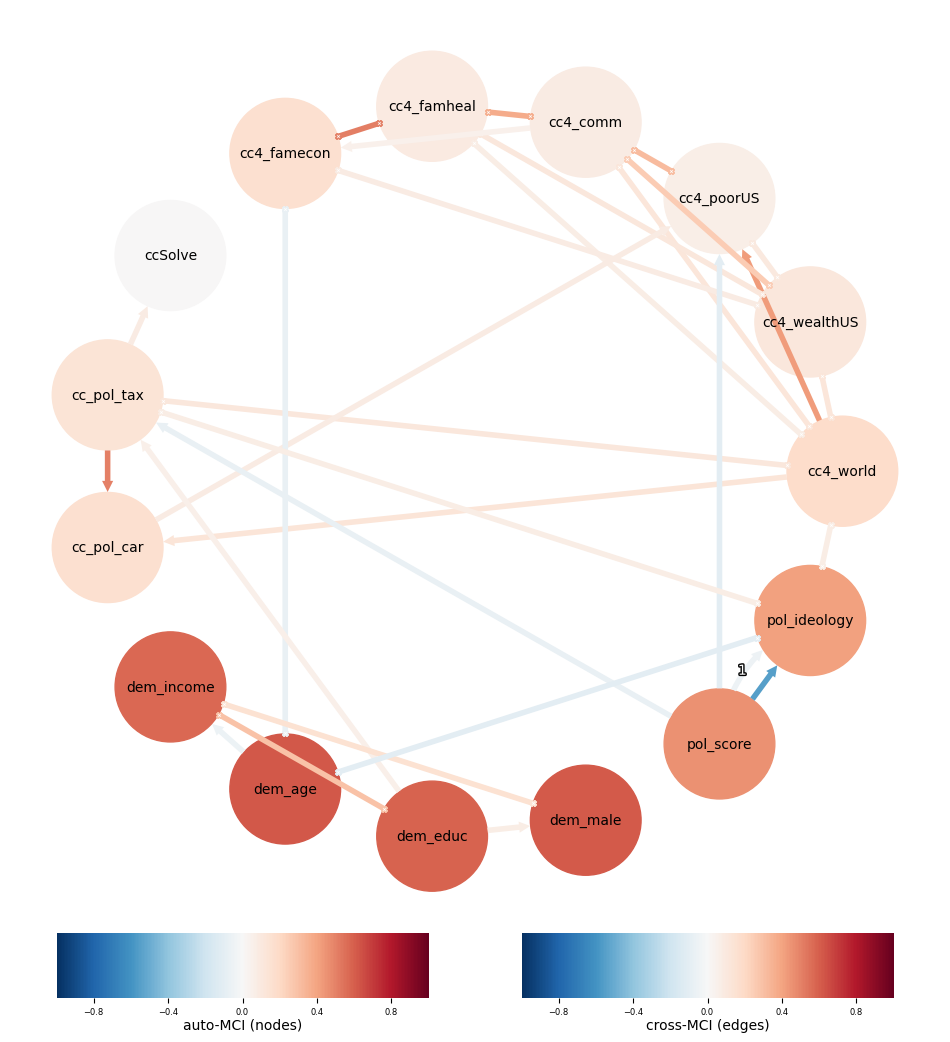

In [89]:
from tigramite import plotting as tp
import matplotlib.pyplot as plt

fig, ax = tp.plot_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=variables,
    figsize=(12, 12),  # Width x Height in inches
    arrow_linewidth=4.0,
    arrowhead_size=30,
    curved_radius=0.3,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)'
)

# Save the figure
fig.savefig("../results/pcmci_graph.png", dpi=600, bbox_inches='tight')

In [90]:
# import numpy as np
# import pandas as pd
# import os
# import tqdm
# from collections import defaultdict
# from tigramite.data_processing import DataFrame
# from tigramite.pcmci import PCMCI
# from tigramite.independence_tests.parcorr import ParCorr

# # --- PARAMETERS ---
# n_bootstrap = 100  # number of bootstrap iterations
# tau_max = 1
# pc_alpha = 0.01
# alpha_level = 0.01

# # --- PREPARE DATA ---
# T, N, C = panel_array.shape
# var_names = variables
# reshaped_data = panel_array.transpose(2, 0, 1).reshape(T * C, N)

# # --- BOOTSTRAPPING LOOP ---
# edge_counter = defaultdict(int)

# for b in tqdm.tqdm(range(n_bootstrap), desc="Bootstrapping"):
#     # Resample time indices with replacement
#     sample_indices = np.random.choice(np.arange(T), size=T, replace=True)
    
#     # Apply same sample across all cross-sections
#     boot_data = panel_array[sample_indices, :, :].transpose(2, 0, 1).reshape(T * C, N)

#     # Create Tigramite dataframe
#     dataframe = DataFrame(data=boot_data, var_names=var_names)

#     # Run PCMCI+
#     pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance='analytic'), verbosity=0)
#     results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)

#     # Record significant edges
#     G = results["graph"]
#     P = results["p_matrix"]

#     for i in range(N):
#         for j in range(N):
#             for tau in range(1, tau_max + 1):
#                 if G[j, i, tau] and P[j, i, tau] < alpha_level:
#                     edge = (var_names[j], var_names[i], tau)
#                     edge_counter[edge] += 1

# # --- EXPORT RESULTS TO CSV ---
# edge_data = [
#     {"source": src, "target": tgt, "lag": tau, "count": count, "frequency": count / n_bootstrap}
#     for (src, tgt, tau), count in edge_counter.items()
# ]
# df_edges = pd.DataFrame(edge_data)

# # Ensure output directory exists
# os.makedirs("../results", exist_ok=True)

# # Save results
# df_edges.to_csv("../results/bootstrapped_pcmci_edges.csv", index=False)

# # Optional: print top results
# print("\nBootstrapped Edge Frequencies:")
# for _, row in df_edges.sort_values(by="frequency", ascending=False).iterrows():
#     print(f"{row['source']} → {row['target']} (lag {row['lag']}): {row['frequency']:.2f}")

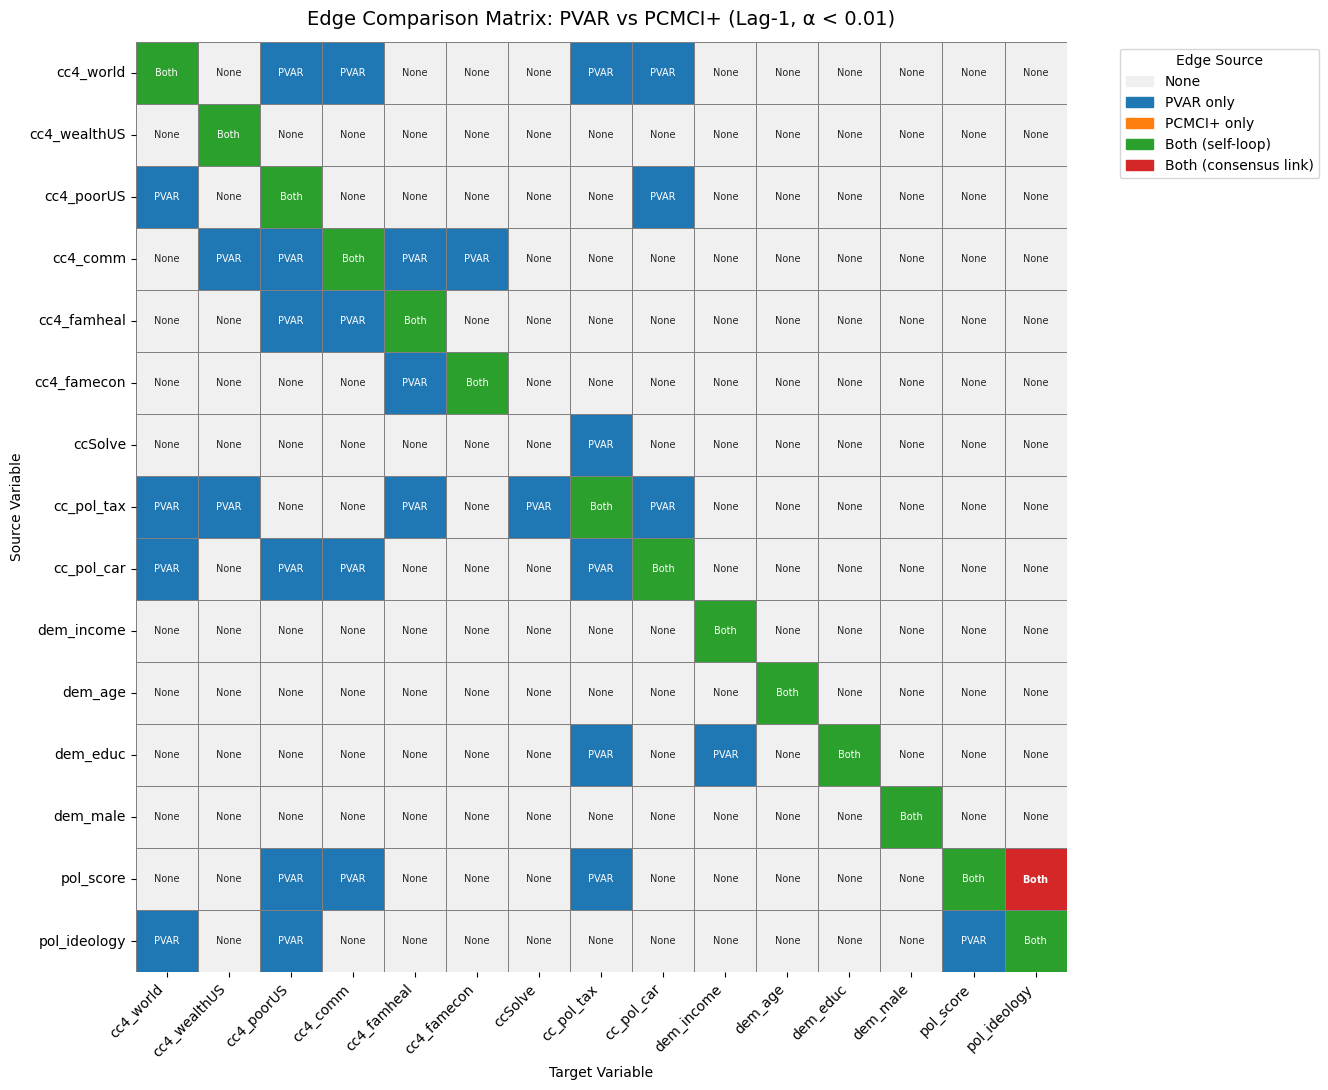

PVAR edges: 46
PCMCI+ edges: 15
Consensus edges: 1


In [91]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import statsmodels.api as sm

# --- Load data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# --- Define predictors ---
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# --- Preprocess ---
data = data.sort_values(by=['PID', 'WAVE'])
for var in variables:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

X_vars = [f"{v}_lag" for v in variables]
Y_vars = variables
df = data.dropna(subset=X_vars + Y_vars)

# --- Run lagged OLS regressions to get PVAR-style edges ---
edges = []
for y in Y_vars:
    X = df[X_vars]
    X = sm.add_constant(X)
    y_vals = df[y]
    model = sm.OLS(y_vals, X).fit()
    for predictor, pval in model.pvalues.items():
        if predictor == 'const' or predictor not in X.columns:
            continue
        if pval < 0.01:
            source = predictor.replace("_lag", "")
            edges.append((source, y, model.params[predictor]))

pvar_edges = [(src, tgt) for (src, tgt, _) in edges]

# --- Get PCMCI+ edges from results object ---
alpha_level = 0.01
pcmci_edges = []
graph = results['graph']
p_matrix = results['p_matrix']

for i in range(len(variables)):  # target
    for j in range(len(variables)):  # source
        if graph[j, i, 1] != 0 and p_matrix[j, i, 1] < alpha_level:
            pcmci_edges.append((variables[j], variables[i]))

# --- Construct the comparison matrix ---
matrix = pd.DataFrame("None", index=variables, columns=variables)

for src, tgt in pvar_edges:
    matrix.loc[src, tgt] = "PVAR"
for src, tgt in pcmci_edges:
    current = matrix.loc[src, tgt]
    if current == "PVAR":
        matrix.loc[src, tgt] = "Both"
    else:
        matrix.loc[src, tgt] = "PCMCI+"

# --- Separate diagonal from consensus (for coloring) ---
color_matrix = pd.DataFrame(0, index=variables, columns=variables)
for i in range(len(variables)):
    for j in range(len(variables)):
        val = matrix.iloc[i, j]
        if val == "None":
            color_matrix.iloc[i, j] = 0
        elif val == "PVAR":
            color_matrix.iloc[i, j] = 1
        elif val == "PCMCI+":
            color_matrix.iloc[i, j] = 2
        elif val == "Both":
            color_matrix.iloc[i, j] = 4 if i != j else 3

# --- Set color map and legend ---
cmap = sns.color_palette([
    "#f0f0f0",  # 0 - None
    "#1f77b4",  # 1 - PVAR only
    "#ff7f0e",  # 2 - PCMCI+ only
    "#2ca02c",  # 3 - Both (self-loop)
    "#d62728"   # 4 - Both (consensus link)
])
legend_labels = {
    0: "None",
    1: "PVAR only",
    2: "PCMCI+ only",
    3: "Both (self-loop)",
    4: "Both (consensus link)"
}

# --- Annotate matrix with bold font for consensus links ---
annotations = matrix.copy()
for i in range(len(variables)):
    for j in range(len(variables)):
        val = matrix.iloc[i, j]
        if val == "Both" and i != j:
            annotations.iloc[i, j] = r"$\bf{" + val + "}$"
        else:
            annotations.iloc[i, j] = val

# --- Plot the heatmap ---
plt.figure(figsize=(13, 11))
ax = sns.heatmap(
    color_matrix,
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    square=True,
    annot=annotations,
    fmt='',
    annot_kws={"size": 7}
)

plt.title("Edge Comparison Matrix: PVAR vs PCMCI+ (Lag-1, α < 0.01)", fontsize=14, pad=12)
plt.xlabel("Target Variable")
plt.ylabel("Source Variable")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

legend_handles = [Patch(color=cmap[i], label=legend_labels[i]) for i in range(5)]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Edge Source")

plt.tight_layout()
plt.savefig("../results/edge_comparison_color_matrix.png", dpi=600)
plt.show()

# --- Debugging output ---
print("PVAR edges:", len(pvar_edges))
print("PCMCI+ edges:", len(pcmci_edges))
print("Consensus edges:", (color_matrix == 4).sum().sum())